In [2]:
# Phase 1A — FAST COMBINE-ONLY (no normalization), Uncompressed NetCDF
# Purpose:
#   1) Combine 2000–2024 EDGAR Transport monthly grids into ONE dataset quickly.
#   2) Avoid slow steps now (no time decode, no lon sorting, no compression).
#   3) Preserve everything needed for later city/county aggregation (sidecars).
#
# Outputs:
#   - data/curated/edgar_transport_2000_2024_rawcombined.nc  (uncompressed, fast to write)
#   - data/curated/grid_cells.parquet                        (lat/lon -> cell_id map)
#   - data/curated/provenance.parquet                        (time_raw -> concat index map)

from pathlib import Path
import xarray as xr
import numpy as np
import pandas as pd
import time

# ------------ config ------------
RAW_DIR = Path("bkl_TRANSPORT_emi_nc")  # folder containing yearly *_TRANSPORT_emi.nc
CURATED_DIR = Path("data/curated")
CURATED_DIR.mkdir(parents=True, exist_ok=True)
OUT_NC = CURATED_DIR / "edgar_transport_2000_2024_rawcombined.nc"


# ------------ small timer helper ------------
def section_timer():
    t = {"last": time.time(), "start": None}

    def tick(label):
        now = time.time()
        if t["start"] is None:
            t["start"] = now
            t["last"] = now
            print(f"[{label}] start")
        else:
            print(f"[{label}] +{now - t['last']:.2f}s (elapsed {now - t['start']:.2f}s)")
            t["last"] = now

    return tick


tick = section_timer()

# ------------ discover files ------------
tick("discover")
files = sorted(RAW_DIR.glob("*TRANSPORT_emi.nc"))
print(f"Found {len(files)} files")
for f in files: print("  -", f.name)
if not files:
    raise FileNotFoundError(f"No files matched in {RAW_DIR}/'*TRANSPORT_emi.nc'")

# ------------ open each file (fast: no time decode) ------------
tick("open_files")
datasets = []
lat0 = lon0 = None
emi_name = None

for i, fp in enumerate(files, 1):
    t0 = time.time()
    ds_y = xr.open_dataset(fp, engine="h5netcdf", decode_times=False)

    # Minimal coord harmonization (NO sorting/reindexing)
    if "longitude" in ds_y.coords and "lon" not in ds_y.coords:
        ds_y = ds_y.rename({"longitude": "lon"})
    if "latitude" in ds_y.coords and "lat" not in ds_y.coords:
        ds_y = ds_y.rename({"latitude": "lat"})

    # Fail-fast: all years must share identical grid arrays (preserves overlap math later)
    if i == 1:
        lat0 = ds_y["lat"].values
        lon0 = ds_y["lon"].values
        emi_name = "emi_co2" if "emi_co2" in ds_y.data_vars else list(ds_y.data_vars)[0]
    else:
        if not (np.array_equal(lat0, ds_y["lat"].values) and np.array_equal(lon0, ds_y["lon"].values)):
            raise ValueError(f"Grid mismatch in {fp.name}. Normalize coords before combining.")
        cur_var = "emi_co2" if "emi_co2" in ds_y.data_vars else list(ds_y.data_vars)[0]
        if cur_var != emi_name:
            ds_y = ds_y.rename({cur_var: emi_name})

    datasets.append(ds_y)
    print(f"[open] {i:02d}/{len(files)} {fp.name} in {time.time() - t0:.2f}s")

tick("concat")
# Be explicit to avoid the compat/coords conflict:
# - data_vars="minimal": only concat variables that actually vary by 'time'
# - coords="minimal": keep only coords along the concat dim (time); lat/lon are identical, so this is fine
# - compat="no_conflicts": allow concat as long as there is no *overlap* conflict
# - combine_attrs="override": skip slow/strict attribute merging
ds = xr.concat(
    datasets,
    dim="time",
    data_vars="minimal",
    coords="minimal",
    compat="no_conflicts",
    combine_attrs="override",
)
print("Dims:", dict(ds.dims))
print("Data variables:", list(ds.data_vars))

# Quick QC (cheap since we didn't reorder)
v = emi_name
vmin = float(ds[v].min().values)
vmax = float(ds[v].max().values)
print(f"[QC] {v}: min={vmin:.3f}, max={vmax:.3f}")

# ------------ save uncompressed NetCDF (fast) ------------
tick("save_uncompressed_netcdf")
# Disable compression for ALL data vars & common coords to avoid slow write
all_write_vars = list(ds.data_vars) + [c for c in ["lat", "lon", "time", "year", "month"] if c in ds.variables]
encoding = {name: {"zlib": False} for name in all_write_vars}

ds.to_netcdf(OUT_NC, engine="h5netcdf", encoding=encoding)
print(f"Saved combined file: {OUT_NC}")

# ------------ sidecars for city/county phase ------------
tick("sidecars")
# Stable cell_id map (one-time)
lat_vals = ds["lat"].values
lon_vals = ds["lon"].values
grid = (
    pd.DataFrame({
        "lat": np.repeat(lat_vals, len(lon_vals)),
        "lon": np.tile(lon_vals, len(lat_vals)),
    })
    .assign(cell_id=lambda d: np.arange(len(d), dtype=np.int64))
)
grid_path = CURATED_DIR / "grid_cells.parquet"
grid.to_parquet(grid_path, index=False)

# Provenance (raw time values as stored; decode later in normalization pass)
prov = pd.DataFrame({
    "index_in_concat": np.arange(ds.dims["time"], dtype=np.int32),
    "time_raw": ds["time"].values.astype("object"),
})
prov_path = CURATED_DIR / "provenance.parquet"
prov.to_parquet(prov_path, index=False)

print(f"Wrote sidecars:\n  - {grid_path}\n  - {prov_path}")
tick("done")

# ------------ brief log you can keep ------------
print("\n[LOG]")
print("• Combined EDGAR Transport yearly NetCDFs with decode_times=False (fast).")
print("• No normalization yet (lon sorting, month-end coercion deferred to Phase 1B/2).")
print("• Wrote uncompressed NetCDF (fast to write; larger on disk).")
print("• Exported sidecars for later city/county aggregation (grid cell_id map, per-time provenance).")

[discover] start
Found 24 files
  - EDGAR_2024_GHG_CO2_2000_bkl_TRANSPORT_emi.nc
  - EDGAR_2024_GHG_CO2_2001_bkl_TRANSPORT_emi.nc
  - EDGAR_2024_GHG_CO2_2002_bkl_TRANSPORT_emi.nc
  - EDGAR_2024_GHG_CO2_2003_bkl_TRANSPORT_emi.nc
  - EDGAR_2024_GHG_CO2_2004_bkl_TRANSPORT_emi.nc
  - EDGAR_2024_GHG_CO2_2005_bkl_TRANSPORT_emi.nc
  - EDGAR_2024_GHG_CO2_2006_bkl_TRANSPORT_emi.nc
  - EDGAR_2024_GHG_CO2_2007_bkl_TRANSPORT_emi.nc
  - EDGAR_2024_GHG_CO2_2008_bkl_TRANSPORT_emi.nc
  - EDGAR_2024_GHG_CO2_2009_bkl_TRANSPORT_emi.nc
  - EDGAR_2024_GHG_CO2_2010_bkl_TRANSPORT_emi.nc
  - EDGAR_2024_GHG_CO2_2011_bkl_TRANSPORT_emi.nc
  - EDGAR_2024_GHG_CO2_2012_bkl_TRANSPORT_emi.nc
  - EDGAR_2024_GHG_CO2_2013_bkl_TRANSPORT_emi.nc
  - EDGAR_2024_GHG_CO2_2014_bkl_TRANSPORT_emi.nc
  - EDGAR_2024_GHG_CO2_2015_bkl_TRANSPORT_emi.nc
  - EDGAR_2024_GHG_CO2_2016_bkl_TRANSPORT_emi.nc
  - EDGAR_2024_GHG_CO2_2017_bkl_TRANSPORT_emi.nc
  - EDGAR_2024_GHG_CO2_2018_bkl_TRANSPORT_emi.nc
  - EDGAR_2024_GHG_CO2_2019_bkl_TRANS

/var/folders/bx/tys9l3gs3t5b_hqdsqy6wc940000gn/T/ipykernel_47039/2210394064.py:97: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("Dims:", dict(ds.dims))


Dims: {'time': 288, 'lat': 1800, 'lon': 3600}
Data variables: ['emissions']
[QC] emissions: min=0.000, max=286868.656
[save_uncompressed_netcdf] +5.90s (elapsed 6.03s)
Saved combined file: data/curated/edgar_transport_2000_2024_rawcombined.nc
[sidecars] +3.47s (elapsed 9.51s)


/var/folders/bx/tys9l3gs3t5b_hqdsqy6wc940000gn/T/ipykernel_47039/2210394064.py:132: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "index_in_concat": np.arange(ds.dims["time"], dtype=np.int32),


Wrote sidecars:
  - data/curated/grid_cells.parquet
  - data/curated/provenance.parquet
[done] +0.77s (elapsed 10.28s)

[LOG]
• Combined EDGAR Transport yearly NetCDFs with decode_times=False (fast).
• No normalization yet (lon sorting, month-end coercion deferred to Phase 1B/2).
• Wrote uncompressed NetCDF (fast to write; larger on disk).
• Exported sidecars for later city/county aggregation (grid cell_id map, per-time provenance).


In [3]:
from pathlib import Path
import xarray as xr
import pandas as pd

OUT_NC = Path("data/curated/edgar_transport_2000_2024_rawcombined.nc")

# 1) File exists and basic size
print("Exists:", OUT_NC.exists(), "| Size (MB):", round(OUT_NC.stat().st_size/1024**2, 1))

# 2) Open (still decode_times=False is fine here)
ds = xr.open_dataset(OUT_NC, engine="h5netcdf", decode_times=False)
print("Dims:", dict(ds.sizes))
print("Vars:", list(ds.data_vars))

# 3) Peek at first/last raw time values (we'll decode in Phase 1B)
print("First raw time:", ds["time"].values[0], "Last raw time:", ds["time"].values[-1])

# 4) Quick totals for one slice
v = "emissions" if "emissions" in ds.data_vars else list(ds.data_vars)[0]
print("Sample monthly global total (first slice):", float(ds[v].isel(time=0).sum()))

Exists: True | Size (MB): 7119.2
Dims: {'time': 288, 'lat': 1800, 'lon': 3600}
Vars: ['emissions']
First raw time: 14.0 Last raw time: 348.0
Sample monthly global total (first slice): 453612000.0


In [4]:
from pathlib import Path
import pandas as pd
import numpy as np
import xarray as xr

CURATED_DIR = Path("data/curated")
OUT_NC = CURATED_DIR / "edgar_transport_2000_2024_rawcombined.nc"

ds = xr.open_dataset(OUT_NC, engine="h5netcdf", decode_times=False)

# grid map
lat_vals = ds["lat"].values
lon_vals = ds["lon"].values
grid = (
    pd.DataFrame({
        "lat": np.repeat(lat_vals, len(lon_vals)),
        "lon": np.tile(lon_vals, len(lat_vals)),
    })
    .assign(cell_id=lambda d: np.arange(len(d), dtype=np.int64))
)

# provenance map
prov = pd.DataFrame({
    "index_in_concat": np.arange(ds.sizes["time"], dtype=np.int32),
    "time_raw": ds["time"].values.astype("object"),
})

def write_with_fallback(df, path_base):
    try:
        df.to_parquet(path_base.with_suffix(".parquet"), index=False)
        print("Wrote", path_base.with_suffix(".parquet"))
    except Exception as e:
        print("Parquet failed (likely pyarrow/fastparquet missing):", e)
        df.to_csv(path_base.with_suffix(".csv"), index=False)
        print("Wrote", path_base.with_suffix(".csv"), "instead")

write_with_fallback(grid, CURATED_DIR / "grid_cells")
write_with_fallback(prov, CURATED_DIR / "provenance")

Wrote data/curated/grid_cells.parquet
Wrote data/curated/provenance.parquet


In [6]:
from pathlib import Path
import xarray as xr
import pandas as pd

OUT_NC = Path("data/curated/edgar_transport_2000_2024_rawcombined.nc")
print("Exists:", OUT_NC.exists(), "| Size (MB):", round(OUT_NC.stat().st_size/1024**2, 1))

ds = xr.open_dataset(OUT_NC, engine="h5netcdf", decode_times=False)
print("Dims:", dict(ds.sizes))
print("Vars:", list(ds.data_vars))
print("First raw time:", ds["time"].values[0], "Last raw time:", ds["time"].values[-1])

v = "emissions" if "emissions" in ds.data_vars else list(ds.data_vars)[0]
print("Sample monthly global total (first slice):", float(ds[v].isel(time=0).sum()))

Exists: True | Size (MB): 7119.2
Dims: {'time': 288, 'lat': 1800, 'lon': 3600}
Vars: ['emissions']
First raw time: 14.0 Last raw time: 348.0
Sample monthly global total (first slice): 453612000.0


In [10]:
from pathlib import Path
import geopandas as gpd
from shapely.geometry import Polygon
from pyogrio import list_layers as pyo_list_layers

CITY_POLY_PATH = Path("data/geo/GHS_UCDB_GLOBE_R2024A_V1_1/GHS_UCDB_GLOBE_R2024A.gpkg")

layers = pyo_list_layers(CITY_POLY_PATH)  # ndarray (2, n) in many pyogrio versions
if hasattr(layers, "shape") and layers.shape[0] == 2:
    names = list(layers[0])
    geom_types = list(layers[1])
else:
    # fallback if a DataFrame/dict-like is returned
    try:
        names = [L["name"] for L in layers]
        geom_types = [L.get("geometry_type") for L in layers]
    except Exception:
        import geopandas as gpd

        df = gpd.list_layers(CITY_POLY_PATH)  # returns a DataFrame
        names = df["name"].tolist()
        geom_types = df.get("geometry_type", [None] * len(names)).tolist()

print("UCDB layers:")
for i, (nm, gt) in enumerate(zip(names, geom_types)):
    print(f"{i:2d}  {nm}  | geometry={gt}")

# peek likely layers for columns (and strip BOM prefixes)
for name in [
    "GHS_UCDB_THEME_GEOGRAPHY_GLOBE_R2024A",
    "GHS_UCDB_THEME_GENERAL_CHARACTERISTICS_GLOBE_R2024A",
    "GHS_UCDB_THEME_GHSL_GLOBE_R2024A",
]:
    if name in names:
        df = gpd.read_file(CITY_POLY_PATH, layer=name, rows=1)
        df.columns = [c.lstrip("\ufeff") for c in df.columns]
        print("\nColumns in", name, "→", list(df.columns)[:30])

UCDB layers:
 0  GHS_UCDB_THEME_CLIMATE_GLOBE_R2024A  | geometry=MultiPolygon
 1  GHS_UCDB_THEME_EMISSIONS_GLOBE_R2024A  | geometry=MultiPolygon
 2  GHS_UCDB_THEME_EXPOSURE_GLOBE_R2024A  | geometry=MultiPolygon
 3  GHS_UCDB_THEME_GENERAL_CHARACTERISTICS_GLOBE_R2024A  | geometry=MultiPolygon
 4  GHS_UCDB_THEME_GEOGRAPHY_GLOBE_R2024A  | geometry=MultiPolygon
 5  GHS_UCDB_THEME_GHSL_GLOBE_R2024A  | geometry=MultiPolygon
 6  GHS_UCDB_THEME_GREENNESS_GLOBE_R2024A  | geometry=MultiPolygon
 7  GHS_UCDB_THEME_HAZARD_RISK_GLOBE_R2024A  | geometry=MultiPolygon
 8  GHS_UCDB_THEME_HEALTH_GLOBE_R2024A  | geometry=MultiPolygon
 9  GHS_UCDB_THEME_INFRASTRUCTURES_GLOBE_R2024A  | geometry=MultiPolygon
10  GHS_UCDB_THEME_LULC_GLOBE_R2024A  | geometry=MultiPolygon
11  GHS_UCDB_THEME_NATURAL_SYSTEMS_GLOBE_R2024A  | geometry=MultiPolygon
12  GHS_UCDB_THEME_SDG_GLOBE_R2024A  | geometry=MultiPolygon
13  GHS_UCDB_THEME_SOCIOECONOMIC_GLOBE_R2024A  | geometry=MultiPolygon
14  GHS_UCDB_THEME_WATER_GLOBE_R2024A  

In [18]:
# Phase 2 — City + State/Province + Country aggregation (auto-detect columns)
# Inputs:
#   - data/curated/edgar_transport_2000_2024_rawcombined.nc
#   - data/geo/cities.*    (GHSL UCDB or other city polygons)
#   - data/geo/admin1.*    (Natural Earth Admin-1 or equivalent)
#   - data/geo/admin0.*    (Natural Earth Admin-0 countries or equivalent)
#
# Output:
#   - data/curated/city-month/transport_city_month.parquet
#   - data/curated/city-year/transport_city_year.parquet

from pathlib import Path
import time
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd

# ------------------ config ------------------
CURATED_DIR = Path("data/curated")
GRID_NC = CURATED_DIR / "edgar_transport_2000_2024_rawcombined.nc"

# Point these to your files (GPKG/SHP/GeoJSON all fine)
CITY_POLY_PATH = Path("data/geo/GHS_UCDB_GLOBE_R2024A_V1_1/GHS_UCDB_GLOBE_R2024A.gpkg")  # GHSL UCDB or other city polygons
ADMIN1_PATH = Path("data/geo/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp")  # state/province polygons (Admin-1)
ADMIN0_PATH = Path("data/geo/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp")  # country polygons (Admin-0)

# Batch size for centroid-in-polygon mapping (keeps memory low)
BATCH_SIZE = 400_000

# Outputs
CITY_MONTH_OUT = CURATED_DIR / "city-month" / "transport_city_month.parquet"
CITY_YEAR_OUT = CURATED_DIR / "city-year" / "transport_city_year.parquet"
CITY_MONTH_OUT.parent.mkdir(parents=True, exist_ok=True)
CITY_YEAR_OUT.parent.mkdir(parents=True, exist_ok=True)


# ------------------ helpers ------------------
def ensure_wgs84(gdf, label):
    if gdf.crs is None:
        raise ValueError(f"{label} CRS is None. Reproject to EPSG:4326 before running.")
    if gdf.crs.to_epsg() != 4326:
        gdf = gdf.to_crs(4326)
    return gdf


def pick_col(gdf, candidates, required=True, label=""):
    for c in candidates:
        if c in gdf.columns:
            return c
    if required:
        raise ValueError(f"None of {candidates} found in {label}. Available: {list(gdf.columns)}")
    return None


# Common column names for popular datasets:
# GHSL UCDB (cities): name candidates often include 'UC_NM_MN', 'UC_NM_LTN', 'name'
CITY_NAME_CANDS = ["UC_NM_MN", "UC_NM_LTN", "name", "NAME", "CITY_NAME"]
CITY_ID_CANDS = ["UC_ID", "ID_HDC_G0", "city_id"]  # if none, we’ll generate one
CITY_COUNTRY_CANDS = ["CTR_MN_NM", "country", "COUNTRY"]

# Natural Earth Admin-1:
ADMIN1_NAME_CANDS = ["name_en", "name", "NAME_1", "GN_NAME"]

# Natural Earth Admin-0:
ADMIN0_NAME_CANDS = ["name_en", "NAME_EN", "name", "NAME"]
ADMIN0_ISO3_CANDS = ["iso_a3", "ISO_A3", "ISO_A3_EH"]

# ------------------ load grid ------------------
t0 = time.time()
print("[2] Load grid cube")
ds = xr.open_dataset(GRID_NC, engine="h5netcdf", decode_times=True)
emi_var = "emissions" if "emissions" in ds.data_vars else list(ds.data_vars)[0]

n_time = ds.sizes["time"]
n_lat = ds.sizes["lat"]
n_lon = ds.sizes["lon"]
lat_vals = ds["lat"].values
lon_vals = ds["lon"].values
n_cells = n_lat * n_lon
print(f"[2] grid dims: time={n_time}, lat={n_lat}, lon={n_lon}, cells={n_cells:,}")

# ------------------ load geographies ------------------
# --- replace ONLY your "Load city polygons" block with THIS ---
print("[2] Load city polygons (UCDB layer selection + strip BOM)")
from pyogrio import list_layers as pyo_list_layers

# Prefer layers that carry names; fall back if needed
PREFERRED_CITY_LAYERS = [
    "GHS_UCDB_THEME_GEOGRAPHY_GLOBE_R2024A",
    "GHS_UCDB_THEME_GENERAL_CHARACTERISTICS_GLOBE_R2024A",
    "GHS_UCDB_THEME_GHSL_GLOBE_R2024A",
]

available = pyo_list_layers(CITY_POLY_PATH)
if hasattr(available, "shape") and available.shape[0] == 2:
    layer_names = set(available[0])
else:
    try:
        layer_names = {L["name"] for L in available}
    except Exception:
        import geopandas as _gpd
        layer_names = set(_gpd.list_layers(CITY_POLY_PATH)["name"].tolist())

CITY_LAYER = next((L for L in PREFERRED_CITY_LAYERS if L in layer_names), next(iter(layer_names)))
print(f"[2] UCDB layer selected: {CITY_LAYER}")

cities = gpd.read_file(CITY_POLY_PATH, layer=CITY_LAYER)
# Strip BOM prefix if present
cities.columns = [c.lstrip("\ufeff") for c in cities.columns]
cities = ensure_wgs84(cities, "cities")

# UCDB R2024A name/id fields (as shown in your probe)
CITY_NAME_CANDS   = ["GC_UCN_MAI_2025", "GC_UCN_LIS_2025", "UC_NM_MN", "UC_NM_LTN", "GC_NAME", "NAME", "name"]
CITY_ID_CANDS     = ["ID_UC_G0", "ID_UC", "ID_HDC_G0", "UC_ID", "city_id"]
CITY_COUNTRY_CANDS= ["GC_CNT_GAD_2025", "CTR_MN_NM", "COUNTRY", "country", "CNTR_NAME"]

CITY_NAME_COL = pick_col(cities, CITY_NAME_CANDS, True,  "cities (name)")
CITY_ID_COL   = pick_col(cities, CITY_ID_CANDS,   False, "cities (id)")
if CITY_ID_COL is None:
    cities["city_id"] = pd.util.hash_pandas_object(
        cities[CITY_NAME_COL].astype("string").str.normalize("NFKD").str.lower(), index=False
    ).astype("int64").astype("string")
    CITY_ID_COL = "city_id"
CITY_COUNTRY_COL = pick_col(cities, CITY_COUNTRY_CANDS, False, "cities (country)")

print(f"[2] Using city columns → name={CITY_NAME_COL}, id={CITY_ID_COL}, country={CITY_COUNTRY_COL}")
# --- end replacement ---

print("[2] Load Admin-1 (state/province)")
adm1 = gpd.read_file(ADMIN1_PATH)
adm1 = ensure_wgs84(adm1, "admin1")
ADMIN1_NAME_COL = pick_col(adm1, ADMIN1_NAME_CANDS, True, "admin1")

print("[2] Load Admin-0 (country)")
adm0 = gpd.read_file(ADMIN0_PATH)
adm0 = ensure_wgs84(adm0, "admin0")
ADMIN0_NAME_COL = pick_col(adm0, ADMIN0_NAME_CANDS, True, "admin0 (country name)")
ADMIN0_ISO3_COL = pick_col(adm0, ADMIN0_ISO3_CANDS, True, "admin0 (iso3)")

# ------------------ enrich cities with admin1/admin0 ------------------
print("[2] Attach state/country to cities (centroid-in-polygon)")
# Compute centroids in an equal-area projection for stability, then return to WGS84
city_pts = cities.to_crs(6933)  # World Equidistant Cylindrical
city_pts["geometry"] = city_pts.geometry.centroid
city_pts = city_pts.to_crs(4326)

c_to_a1 = gpd.sjoin(
    city_pts[[CITY_ID_COL, CITY_NAME_COL, "geometry"]],
    adm1[[ADMIN1_NAME_COL, "geometry"]],
    how="left", predicate="within"
).drop(columns=["index_right"]).rename(columns={ADMIN1_NAME_COL: "admin1_name"})

c_to_a0 = gpd.sjoin(
    city_pts[[CITY_ID_COL, CITY_NAME_COL, "geometry"]],
    adm0[[ADMIN0_NAME_COL, ADMIN0_ISO3_COL, "geometry"]],
    how="left", predicate="within"
).drop(columns=["index_right"]).rename(columns={ADMIN0_NAME_COL: "country_name", ADMIN0_ISO3_COL: "iso3"})

city_enriched = (cities[[CITY_ID_COL, CITY_NAME_COL]]
                 .merge(c_to_a1[[CITY_ID_COL, "admin1_name"]], on=CITY_ID_COL, how="left")
                 .merge(c_to_a0[[CITY_ID_COL, "country_name", "iso3"]], on=CITY_ID_COL, how="left"))

# If city layer already had country names, prefer them (optional)
if CITY_COUNTRY_COL:
    city_enriched["country_name"] = cities[CITY_COUNTRY_COL].astype("string")

city_enriched = (city_enriched
                 .drop_duplicates(CITY_ID_COL)
                 .set_index(CITY_ID_COL)
                 .astype({"admin1_name": "string", "country_name": "string", "iso3": "string"}))

print(f"[2] Enriched cities: {len(city_enriched):,}")

# ------------------ map grid cells → cities (batched) ------------------
print("[2] Map grid cell centroids → cities (batched)")
print(f"[2] grid lon range: {float(lon_vals.min()):.2f} .. {float(lon_vals.max()):.2f}")
print(f"[2] grid lat range: {float(lat_vals.min()):.2f} .. {float(lat_vals.max()):.2f}")
print(f"[2] cities bounds (minx,miny,maxx,maxy): {tuple(map(float, cities.total_bounds))}")
lat_rep = np.repeat(lat_vals, n_lon)
lon_tile = np.tile(lon_vals, n_lat)
# Wrap longitudes from [0,360] to [-180,180] for point-in-polygon join
lon_tile_wrapped = np.where(lon_tile > 180, lon_tile - 360, lon_tile)
cell_to_city_idx = np.full(n_cells, -1, dtype=np.int32)

# Compact city index for fast aggregation
# Compact city index for fast aggregation (robust to pandas StringArray)
city_index = (
    pd.Index(cities[CITY_ID_COL].astype("string"))
      .drop_duplicates()
      .sort_values()
)
city_to_idx = dict(zip(city_index, np.arange(len(city_index), dtype=np.int32)))

cities_small = cities[[CITY_ID_COL, CITY_NAME_COL, "geometry"]].reset_index(drop=True)
# Validate/fix polygon geometries (handles tiny self-intersections)
cities_small["geometry"] = cities_small["geometry"].buffer(0)

# Randomized smoke-test across the full grid to choose join strategy
import numpy as np
rng = np.random.default_rng(42)
_k = min(20000, n_cells)
_idx = rng.integers(0, n_cells, size=_k, dtype=np.int64)
_pts0 = gpd.GeoDataFrame(
    {"cell_id": _idx},
    geometry=gpd.points_from_xy(lon_tile_wrapped[_idx], lat_rep[_idx]),
    crs="EPSG:4326"
)
_joined0 = gpd.sjoin(_pts0, cities_small, how="left", predicate="intersects")
_hits_intersects = int(_joined0[CITY_ID_COL].notna().sum())
print(f"[2] smoke-test(intersects): matched {_hits_intersects} / {_k}")
USE_NEAREST = False
if _hits_intersects == 0:
    try:
        _joined1 = gpd.sjoin_nearest(_pts0, cities_small, how='left', max_distance=0.25)  # ~25 km
        _hits_nearest = int(_joined1[CITY_ID_COL].notna().sum())
        print(f"[2] smoke-test(nearest 0.25°): matched {_hits_nearest} / {_k}")
        if _hits_nearest > 0:
            USE_NEAREST = True
            print("[2] Using sjoin_nearest with max_distance=0.25° for mapping.")
    except Exception as _e:
        print("[2] sjoin_nearest unavailable or failed:", _e)

num_batches = int(np.ceil(n_cells / BATCH_SIZE))
t_batch = time.time()
for b in range(num_batches):
    start, end = b * BATCH_SIZE, min((b + 1) * BATCH_SIZE, n_cells)
    if start >= end: break

    pts = gpd.GeoDataFrame(
        {"cell_id": np.arange(start, end, dtype=np.int64),
        "lon": lon_tile_wrapped[start:end], "lat": lat_rep[start:end]},
        geometry=gpd.points_from_xy(lon_tile_wrapped[start:end], lat_rep[start:end]),
        crs="EPSG:4326"
    )
    # Use 'intersects' to be robust to boundary-touching cells; many UCDB polygons are very tight
    if USE_NEAREST:
            joined = gpd.sjoin_nearest(pts, cities_small, how="left", max_distance=0.25).dropna(subset=[CITY_ID_COL])
    else:
        joined = gpd.sjoin(pts, cities_small, how="left", predicate="intersects").dropna(subset=[CITY_ID_COL])
    if not joined.empty:
        idxs = joined[CITY_ID_COL].astype("string").map(city_to_idx)  # pandas Series of ints or NaN
        idxs = idxs.fillna(-1).astype(np.int32).to_numpy()
        cid  = joined["cell_id"].to_numpy()
        valid = idxs >= 0
        cell_to_city_idx[cid[valid]] = idxs[valid]

    if (b + 1) % max(1, num_batches // 20) == 0 or b == num_batches - 1:
        print(
            f"  batch {b + 1}/{num_batches} mapped; hit-rate {(cell_to_city_idx >= 0).mean():.2%}; +{time.time() - t_batch:.1f}s")
        t_batch = time.time()

print(f"[2] Mapped cells: {(cell_to_city_idx >= 0).mean():.2%}")

# ------------------ aggregate city-month & city-year ------------------
print("[2] Aggregate city-month")
times = pd.to_datetime(ds["time"].values)

meta = city_enriched.reindex(city_index)
city_names = meta[CITY_NAME_COL].astype("string").to_numpy()
admin1_names = meta["admin1_name"].astype("string").fillna("").to_numpy()
country_names = meta["country_name"].astype("string").fillna("").to_numpy()
iso3_codes = meta["iso3"].astype("string").fillna("").to_numpy()

parts = []
for tpos in range(n_time):
    arr = ds[emi_var].isel(time=tpos).values.astype("float64", copy=False).reshape(-1)
    sel = cell_to_city_idx >= 0
    sums = np.bincount(cell_to_city_idx[sel], weights=arr[sel], minlength=len(city_index))
    nz = np.flatnonzero(sums)
    if nz.size:
        parts.append(pd.DataFrame({
            "time": np.repeat(times[tpos], nz.size),
            "city_id": city_index[nz].to_numpy(),
            "city_name": city_names[nz],
            "admin1_name": admin1_names[nz],
            "country_name": country_names[nz],
            "iso3": iso3_codes[nz],
            "emissions_tonnes": sums[nz],
        }))

city_month = (pd.concat(parts, ignore_index=True)
              if parts else
              pd.DataFrame(
                  columns=["time", "city_id", "city_name", "admin1_name", "country_name", "iso3", "emissions_tonnes"]))
city_month["MtCO2"] = city_month["emissions_tonnes"] / 1e6
city_month.to_parquet(CITY_MONTH_OUT, index=False)
print(f"[2] wrote city-month: {CITY_MONTH_OUT} (rows={len(city_month):,})")

print("[2] Aggregate city-year")
city_year = (city_month
             .assign(year=lambda d: pd.to_datetime(d["time"]).dt.year.astype("int16"))
             .groupby(["city_id", "city_name", "admin1_name", "country_name", "iso3", "year"], as_index=False)[
                 "emissions_tonnes"].sum())
city_year["MtCO2"] = city_year["emissions_tonnes"] / 1e6
city_year.to_parquet(CITY_YEAR_OUT, index=False)
print(f"[2] wrote city-year:  {CITY_YEAR_OUT} (rows={len(city_year):,})")

print(f"[2] done in {time.time() - t0:.1f}s")

[2] Load grid cube
[2] grid dims: time=288, lat=1800, lon=3600, cells=6,480,000
[2] Load city polygons (UCDB layer selection + strip BOM)
[2] UCDB layer selected: GHS_UCDB_THEME_GEOGRAPHY_GLOBE_R2024A
[2] Using city columns → name=GC_UCN_MAI_2025, id=ID_UC_G0, country=GC_CNT_GAD_2025
[2] Load Admin-1 (state/province)
[2] Load Admin-0 (country)
[2] Attach state/country to cities (centroid-in-polygon)
[2] Enriched cities: 11,422
[2] Map grid cell centroids → cities (batched)
[2] grid lon range: -179.95 .. 179.95
[2] grid lat range: -89.95 .. 89.95
[2] cities bounds (minx,miny,maxx,maxy): (-175.23890763674552, -54.835032173468, 178.53124943290726, 69.7073241151914)
[2] smoke-test(intersects): matched 26 / 20000
  batch 1/17 mapped; hit-rate 0.00%; +0.1s
  batch 2/17 mapped; hit-rate 0.00%; +0.1s
  batch 3/17 mapped; hit-rate 0.00%; +0.1s
  batch 4/17 mapped; hit-rate 0.00%; +0.1s
  batch 5/17 mapped; hit-rate 0.00%; +0.1s
  batch 6/17 mapped; hit-rate 0.00%; +0.1s
  batch 7/17 mapped; hit

In [19]:
import pandas as pd
cm = pd.read_parquet("data/curated/city-month/transport_city_month.parquet")
cy = pd.read_parquet("data/curated/city-year/transport_city_year.parquet")
print(len(cm), "city-month rows  |  ", len(cy), "city-year rows")
print(cm.head(3)); print(cy.head(3))

0 city-month rows  |   0 city-year rows
Empty DataFrame
Columns: [time, city_id, city_name, admin1_name, country_name, iso3, emissions_tonnes, MtCO2]
Index: []
Empty DataFrame
Columns: [city_id, city_name, admin1_name, country_name, iso3, year, emissions_tonnes, MtCO2]
Index: []


In [20]:
# top cities in earliest + latest year
ymin, ymax = int(cy["year"].min()), int(cy["year"].max())
print("Top", ymin); print(cy.query("year==@ymin").nlargest(10, "emissions_tonnes")
      [["city_name","admin1_name","country_name","iso3","year","MtCO2"]])
print("Top", ymax); print(cy.query("year==@ymax").nlargest(10, "emissions_tonnes")
      [["city_name","admin1_name","country_name","iso3","year","MtCO2"]])

ValueError: cannot convert float NaN to integer

In [16]:
import xarray as xr, pandas as pd
ds = xr.open_dataset("data/curated/edgar_transport_2000_2024_rawcombined.nc", engine="h5netcdf", decode_times=True)
v = "emissions" if "emissions" in ds.data_vars else list(ds.data_vars)[0]
global_month = ds[v].sum(dim=("lat","lon")).to_series()
global_year  = global_month.resample("A-DEC").sum(); global_year.index = global_year.index.year
cy_sum = cy.groupby("year")["emissions_tonnes"].sum()
cov = (cy_sum / global_year.reindex(cy_sum.index)).rename("coverage_ratio")
print(cov.describe()); print(cov.head())

/var/folders/bx/tys9l3gs3t5b_hqdsqy6wc940000gn/T/ipykernel_47039/1895893438.py:5: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  global_year  = global_month.resample("A-DEC").sum(); global_year.index = global_year.index.year


count       0
unique      0
top       NaN
freq      NaN
Name: coverage_ratio, dtype: object
Series([], Name: coverage_ratio, dtype: object)


In [94]:
# Phase 2 — City + State/Province + Country via UCDB polygons (buffered) intersects → centroid nearest fallback (hybrid)
# - Attach ISO3/Admin-1 to UCDB city centroids (spatial joins in WGS84).
# - Map each EDGAR grid cell to a city by:
#     1) UCDB polygon (buffered) intersects by country (ISO3)
#     2) fallback: nearest centroid with adaptive radii by country density (meters, EPSG:6933)
# - Aggregate to city-month and city-year.
#
# Requires: geopandas, pyogrio, rtree/pygeos
# Inputs:
#   data/curated/edgar_transport_2000_2024_rawcombined.nc
#   data/geo/GHS_UCDB_GLOBE_R2024A_V1_1/GHS_UCDB_GLOBE_R2024A.gpkg
#   data/geo/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp
#   data/geo/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp

from pathlib import Path
import time
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
from pyogrio import list_layers as pyo_list_layers

# ------------------ config ------------------
CURATED_DIR = Path("data/curated")
GRID_NC = Path("data/curated/edgar_transport_2000_2024_rawcombined_fixedtime.nc")
NC = Path("data/curated/edgar_transport_2000_2024_rawcombined_fixedtime.nc")

CITY_GPKG = Path("data/geo/GHS_UCDB_GLOBE_R2024A_V1_1/GHS_UCDB_GLOBE_R2024A.gpkg")  # UCDB R2024A
ADMIN1_PATH = Path("data/geo/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp")
ADMIN0_PATH = Path("data/geo/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp")

BATCH_SIZE = 400_000
CRS_WGS84 = "EPSG:4326"
CRS_METRIC = "EPSG:6933"  # Equal-area (meters) -> safe for distance thresholds
BASE_RADIUS_M = 150_000  # ~150 km first pass
MAX_RADIUS_M = 600_000  # ~600 km fallback

CITY_MONTH_OUT = CURATED_DIR / "city-month" / "transport_city_month.parquet"
CITY_YEAR_OUT = CURATED_DIR / "city-year" / "transport_city_year.parquet"
CITY_MONTH_OUT.parent.mkdir(parents=True, exist_ok=True)
CITY_YEAR_OUT.parent.mkdir(parents=True, exist_ok=True)


# ------------------ helpers ------------------
def ensure_wgs84(gdf, label):
    if gdf.crs is None:
        raise ValueError(f"{label} CRS is None. Reproject to EPSG:4326 before running.")
    if gdf.crs.to_epsg() != 4326:
        gdf = gdf.to_crs(4326)
    return gdf


def pick_col(gdf, candidates, label, required=True):
    for c in candidates:
        if c in gdf.columns:
            return c
    if required:
        raise ValueError(f"[{label}] none of {candidates} found. Have: {list(gdf.columns)}")
    return None


# ------------------ load grid ------------------
t0 = time.time()
print("[2] Load grid cube")
ds = xr.open_dataset(GRID_NC, engine="h5netcdf", decode_times=True)
emi_var = "emissions" if "emissions" in ds.data_vars else list(ds.data_vars)[0]
n_time, n_lat, n_lon = ds.sizes["time"], ds.sizes["lat"], ds.sizes["lon"]
lat_vals = ds["lat"].values;
lon_vals = ds["lon"].values
n_cells = n_lat * n_lon
print(f"[2] grid dims: time={n_time}, lat={n_lat}, lon={n_lon}, cells={n_cells:,}")

# Flatten grid coordinates; wrap longitudes if needed (0..360 -> -180..180)
lat_rep = np.repeat(lat_vals, n_lon)
lon_tile = np.tile(lon_vals, n_lat)
lon_tile_wrapped = np.where(lon_tile > 180, lon_tile - 360, lon_tile)

# ------------------ admin layers ------------------
print("[2] Load Admin-1 / Admin-0")
adm1 = ensure_wgs84(gpd.read_file(ADMIN1_PATH), "admin1")
adm0 = ensure_wgs84(gpd.read_file(ADMIN0_PATH), "admin0")
adm0["geometry"] = adm0.geometry.buffer(0)  # fix tiny self-intersections

ADMIN1_NAME_COL = pick_col(adm1, ["name_en", "name", "NAME_1", "GN_NAME"], "admin1")
ADMIN0_NAME_COL = pick_col(adm0, ["name_en", "NAME_EN", "name", "NAME"], "admin0 (name)")
ADMIN0_ISO3_COL = pick_col(adm0, ["iso_a3", "ISO_A3", "ISO_A3_EH"], "admin0 (iso3)")

# ------------------ UCDB centroids + attributes ------------------
print("[2] Load UCDB centroids + join attributes")
uc_cent = gpd.read_file(CITY_GPKG, layer="UC_centroids")
uc_cent.columns = [c.lstrip("\ufeff") for c in uc_cent.columns]
uc_cent = ensure_wgs84(uc_cent, "ucdb_centroids")
if "ID_UC_G0" not in uc_cent.columns:
    raise ValueError("UC_centroids layer missing 'ID_UC_G0'.")

PREFERRED_ATTR_LAYERS = [
    "GHS_UCDB_THEME_GEOGRAPHY_GLOBE_R2024A",
    "GHS_UCDB_THEME_GENERAL_CHARACTERISTICS_GLOBE_R2024A",
    "GHS_UCDB_THEME_GHSL_GLOBE_R2024A",
]
avail = pyo_list_layers(CITY_GPKG)
try:
    names = set(avail[0]) if hasattr(avail, "shape") and avail.shape[0] == 2 else {L["name"] for L in avail}
except Exception:
    names = set(gpd.list_layers(CITY_GPKG)["name"].tolist())
attr_layer = next((L for L in PREFERRED_ATTR_LAYERS if L in names), PREFERRED_ATTR_LAYERS[0])

attrs = gpd.read_file(CITY_GPKG, layer=attr_layer)
attrs.columns = [c.lstrip("\ufeff") for c in attrs.columns]
keep_cols = [c for c in [
    "ID_UC_G0", "GC_UCN_MAI_2025", "GC_UCN_LIS_2025", "UC_NM_MN", "UC_NM_LTN", "GC_CNT_GAD_2025", "COUNTRY", "country"
] if c in attrs.columns]
attrs = attrs[keep_cols].drop_duplicates("ID_UC_G0")

cities_cent = uc_cent.merge(attrs, on="ID_UC_G0", how="left")
cities_cent = ensure_wgs84(cities_cent, "cities_cent")

CITY_ID_COL = "ID_UC_G0"
CITY_NAME_COL = pick_col(cities_cent, ["GC_UCN_MAI_2025", "GC_UCN_LIS_2025", "UC_NM_MN", "UC_NM_LTN"],
                         "ucdb_centroids (name)")
CITY_COUNTRY_COL = pick_col(cities_cent, ["GC_CNT_GAD_2025", "COUNTRY", "country"], "ucdb_centroids (country)",
                            required=False)
print(f"[2] Centroid columns → id={CITY_ID_COL}, name={CITY_NAME_COL}, country={CITY_COUNTRY_COL}")

# ISO3 via spatial Admin-0 (robust to name mismatches)
print("[2] Attach ISO3 to city centroids (spatial Admin-0)")
cent = gpd.sjoin(
    cities_cent[[CITY_ID_COL, CITY_NAME_COL, "geometry"]],
    adm0[[ADMIN0_NAME_COL, ADMIN0_ISO3_COL, "geometry"]],
    how="left", predicate="within"
).drop(columns=["index_right"]).rename(columns={ADMIN0_NAME_COL: "country_name", ADMIN0_ISO3_COL: "iso3"})
cent = ensure_wgs84(cent, "cent")
cent["iso3"] = cent["iso3"].astype("string")
print(f"[2] city centroids with ISO3: {cent['iso3'].notna().sum()} / {len(cent)}")

#
# ------------------ UCDB polygons (urban extents) with buffer ------------------
# We will map cells to cities by polygon intersects first, then use nearest centroids as fallback.
print("[2] Load UCDB polygons (urban extents) and build buffered geometry")
UCDB_GEOG_LAYER = "GHS_UCDB_THEME_GEOGRAPHY_GLOBE_R2024A"
cities_poly_raw = gpd.read_file(CITY_GPKG, layer=UCDB_GEOG_LAYER)
cities_poly_raw.columns = [c.lstrip("\ufeff") for c in cities_poly_raw.columns]
cities_poly_raw = ensure_wgs84(cities_poly_raw, "ucdb_polygons")

# Pick name/id/country columns from polygons (align with centroids naming we picked above)
POLY_NAME_COL = CITY_NAME_COL if CITY_NAME_COL in cities_poly_raw.columns else \
                next((c for c in ["GC_UCN_MAI_2025","GC_UCN_LIS_2025","UC_NM_MN","UC_NM_LTN","NAME","name"] if c in cities_poly_raw.columns), None)
POLY_ID_COL = "ID_UC_G0" if "ID_UC_G0" in cities_poly_raw.columns else \
              next((c for c in ["ID_UC","ID_HDC_G0","UC_ID","city_id"] if c in cities_poly_raw.columns), None)
if POLY_ID_COL is None:
    # generate stable id hash if missing
    cities_poly_raw["city_id"] = pd.util.hash_pandas_object(cities_poly_raw[POLY_NAME_COL].astype("string").str.normalize("NFKD").str.lower(), index=False).astype("int64").astype("string")
    POLY_ID_COL = "city_id"

# Keep only needed columns to reduce memory; we'll attach ISO3 via spatial join to Admin-0 (same as centroids)
cities_poly = cities_poly_raw[[POLY_ID_COL, POLY_NAME_COL, "geometry"]].rename(columns={POLY_ID_COL: "ID_UC_G0", POLY_NAME_COL: CITY_NAME_COL})
# Attach ISO3 to polygons using Admin-0 intersects
poly_to_iso = gpd.sjoin(
    cities_poly[["ID_UC_G0", CITY_NAME_COL, "geometry"]],
    adm0[[ADMIN0_NAME_COL, ADMIN0_ISO3_COL, "geometry"]],
    how="left", predicate="intersects"
).drop(columns=["index_right"]).rename(columns={ADMIN0_ISO3_COL: "iso3"})
cities_poly = cities_poly.merge(poly_to_iso[["ID_UC_G0","iso3"]], on="ID_UC_G0", how="left")
cities_poly["iso3"] = cities_poly["iso3"].astype("string")

# Align polygon IDs to the centroid universe to avoid ID mismatches
cent_ids = set(cent[CITY_ID_COL].astype("string").unique())
before_poly_n = cities_poly.shape[0]
cities_poly = cities_poly[cities_poly["ID_UC_G0"].astype("string").isin(cent_ids)].copy()
after_poly_n = cities_poly.shape[0]
poly_ids = set(cities_poly["ID_UC_G0"].astype("string").unique())
overlap = len(poly_ids & cent_ids)
print(f"[2] ID overlap poly↔centroids: {overlap} / poly={len(poly_ids)} ; cent={len(cent_ids)} (kept {after_poly_n}/{before_poly_n} rows)")

# Buffer polygons in meters to capture fringe cells (tunable)
BUFFER_KM = 30  # 10–20 km typical
cities_poly_buf = cities_poly.to_crs(CRS_METRIC)
# Clean invalid geometries before buffering to avoid empty joins
cities_poly_buf["geometry"] = cities_poly_buf.geometry.buffer(0)
# Apply buffer
cities_poly_buf["geometry"] = cities_poly_buf.geometry.buffer(BUFFER_KM * 1_000)
cities_poly_buf = cities_poly_buf.to_crs(CRS_WGS84)

# --- Guard A: drop empties/NaNs and re-clean after back-transform ---
cities_poly_buf = cities_poly_buf[
    cities_poly_buf.geometry.notna() & (~cities_poly_buf.geometry.is_empty)
].copy()
# Repair again in WGS84 to ensure valid rings after back-transform
cities_poly_buf["geometry"] = cities_poly_buf.buffer(0)
print("[2] buffered polygons:", len(cities_poly_buf), "| valid:", int(cities_poly_buf.is_valid.sum()))

# Per-ISO polygon pools (for intersects) — keep only geometry & identity/name
poly_by_iso = {
    k: g[["ID_UC_G0", CITY_NAME_COL, "geometry"]].reset_index(drop=True)
    for k, g in cities_poly_buf.groupby("iso3", dropna=False)
}

# Admin-1 for city centroids
print("[2] Attach Admin-1 to city centroids")
c_to_a1 = gpd.sjoin(
    cent[[CITY_ID_COL, "geometry"]],
    adm1[[ADMIN1_NAME_COL, "geometry"]],
    how="left", predicate="within"
).drop(columns=["index_right"]).rename(columns={ADMIN1_NAME_COL: "admin1_name"})
cent = cent.merge(c_to_a1[[CITY_ID_COL, "admin1_name"]], on=CITY_ID_COL, how="left")
cent["admin1_name"] = cent["admin1_name"].astype("string")

# ------------------ grid → country (Admin-0) once ------------------
print("[2] Map grid cells to Admin-0 countries")
pts_all = gpd.GeoDataFrame(
    {"cid": np.arange(n_cells, dtype=np.int64)},
    geometry=gpd.points_from_xy(lon_tile_wrapped, lat_rep),
    crs=CRS_WGS84
)
adm0_small = adm0[[ADMIN0_NAME_COL, ADMIN0_ISO3_COL, "geometry"]].copy()
try:
    g2c = gpd.sjoin(pts_all, adm0_small, how="left", predicate="intersects").drop(columns=["index_right"])
except Exception as _e:
        print("[2] Admin-0 sjoin(intersects) failed, falling back to nearest(200km):", _e)
        g2c = gpd.sjoin_nearest(pts_all.to_crs(CRS_METRIC), adm0_small.to_crs(CRS_METRIC),
                            how="left", max_distance=200_000
                           ).drop(columns=["index_right"]).to_crs(CRS_WGS84)
cell_iso3 = g2c[ADMIN0_ISO3_COL].astype("string").reindex(range(n_cells)).to_numpy()
nonnull = int(np.count_nonzero(pd.notna(cell_iso3)))
print(f"[2] grid→country assigned iso3 for {nonnull:,}/{n_cells:,} cells ({nonnull / n_cells:.2%})")
USE_GLOBAL_NEAREST = nonnull / n_cells < 0.01

# ------------------ HYBRID: polygons (buffered) intersects → centroids nearest ------------------
print("[2] Hybrid mapping: UCDB polygons (buffered) intersects first")
cell_to_city_idx = np.full(n_cells, -1, dtype=np.int32)

# Compact city index from centroids (ensures the same universe across both steps)
city_index = pd.Index(cent[CITY_ID_COL].astype("string")).drop_duplicates().sort_values()
city_to_idx = dict(zip(city_index, np.arange(len(city_index), dtype=np.int32)))

# 2A) POLYGON INTERSECTS (buffered) — GLOBAL join (more robust than ISO-buckets)
print("[2] Polygon step: global sjoin against buffered UCDB polygons (REVERSED join)")
# Build a single polygon table (already buffered & WGS84)
poly_all = (pd.concat(poly_by_iso.values(), ignore_index=True)
            if len(poly_by_iso)
            else cities_poly_buf[["ID_UC_G0", CITY_NAME_COL, "geometry"]])

# Reverse join: polygons (left) → points (right) — more robust across environments
try:
    jrev = gpd.sjoin(poly_all, pts_all, how="left", predicate="intersects").drop(columns=["index_right"])
except Exception as _e:
    print("[2] polygon reverse sjoin failed on 'contains' →", _e)
    jrev = gpd.sjoin(poly_all, pts_all, how="left", predicate="intersects").drop(columns=["index_right"])

_has_cid = "cid" in jrev.columns
_has_id  = "ID_UC_G0" in jrev.columns
print("[2] poly_all:", len(poly_all), "| jrev rows:", len(jrev),
      "| has cid:", _has_cid, "| has ID:", _has_id,
      "| matched cids:", (jrev["cid"].notna().sum() if _has_cid else 0))

# Deterministic scatter: for cells with multiple polygon hits, keep the first
if _has_cid and _has_id:
    _ids  = jrev["ID_UC_G0"].astype("string")
    _cid  = jrev["cid"].astype("Int64")  # nullable-safe then cast
    _code = pd.Categorical(_ids, categories=city_index).codes.astype(np.int32)  # -1 if not in universe
    _ok   = (_code >= 0) & _cid.notna()
    if _ok.any():
        _assign = pd.DataFrame({
            "cid": _cid[_ok].astype("int64").to_numpy(),
            "code": _code[_ok]
        }).drop_duplicates("cid", keep="first")
        cell_to_city_idx[_assign["cid"].to_numpy()] = _assign["code"].to_numpy()

mapped_after_poly = (cell_to_city_idx >= 0).mean()
print(f"[2] After polygon step: mapped cells = {mapped_after_poly:.2%}")
# Build points-with-ISO table for nearest fallback
pts_iso = pts_all[["cid","geometry"]].join(pd.Series(cell_iso3, name="iso3"))

# 2B) NEAREST CENTROIDS (fallback) with adaptive radii by country density
print("[2] Nearest-centroid fallback with adaptive radii by ISO density")
# Prebuild centroid pools per-ISO
cent_by_iso = {k: v.reset_index(drop=True) for k, v in cent.groupby("iso3", dropna=False)}
pool_global = cent[[CITY_ID_COL, CITY_NAME_COL, "geometry"]].reset_index(drop=True)
if int(cent["iso3"].notna().sum()) == 0:
    USE_GLOBAL_NEAREST = True
    print("[2] No ISO3 on centroids; using global nearest.")

# Precompute per-ISO density to set radii
iso_counts = {iso: len(g) for iso, g in cent_by_iso.items() if pd.notna(iso)}
def _radii_for_iso(iso):
    n = iso_counts.get(iso, 0)
    # Dense country → tighter radii; sparse → wider
    if n >= 200:
        return 100_000, 300_000   # 75km / 200km
    elif n >= 50:
        return 150_000, 450_000  # 100km / 300km
    else:
        return 200_000, 800_000  # 150km / 600km

miss_mask = cell_to_city_idx < 0
miss_ct = int(miss_mask.sum())
print(f"[2] Nearest fallback candidates: {miss_ct:,} cells")

if miss_ct > 0:
    pts_miss = pts_iso.loc[miss_mask, ["cid","iso3","geometry"]]
    for iso, pts_iso_wgs in pts_miss.groupby("iso3", dropna=False):
        if pts_iso_wgs.empty:
            continue

        # Choose pool priority: iso → global (if enabled)
        if (pd.isna(iso) or (iso not in cent_by_iso)):
            # Guarded global fallback for points with missing ISO bucket
            pool = pool_global[[CITY_ID_COL, CITY_NAME_COL, "geometry"]].to_crs(CRS_METRIC)
            r1, r2 = 150_000, 600_000  # conservative default for global
        else:
            pool = cent_by_iso[iso][[CITY_ID_COL, CITY_NAME_COL, "geometry"]].to_crs(CRS_METRIC)
            r1, r2 = _radii_for_iso(iso)

        pts_proj = pts_iso_wgs.to_crs(CRS_METRIC)

        # Pass 1
        joined = gpd.sjoin_nearest(pts_proj, pool, how="left", max_distance=r1)
        # Pass 2 (wider)
        if joined[CITY_ID_COL].isna().all():
                joined = gpd.sjoin_nearest(pts_proj, pool, how="left", max_distance=r2)

        # Scatter results
        idxs = joined[CITY_ID_COL].astype("string").map(city_to_idx).fillna(-1).astype(np.int32).to_numpy()
        cid  = joined["cid"].to_numpy()
        ok   = idxs >= 0
        if ok.any():
            cell_to_city_idx[cid[ok]] = idxs[ok]
mapped_final = (cell_to_city_idx >= 0).mean()
print(f"[2] Final mapped cells (poly + nearest): {mapped_final:.2%}")

# ---- helpers: robust parquet writer + dtype coercers ----
def _safe_write_parquet(df: pd.DataFrame, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    try:
        # PyArrow is picky with pandas' nullable dtypes; coerce to Arrow-friendly ones
        df2 = df.copy()
        for c in df2.columns:
            # Avoid pandas StringDtype -> ArrowTypeError; use plain Python objects
            if pd.api.types.is_string_dtype(df2[c]):
                df2[c] = df2[c].astype(object)
            # If integer column has NA, make it a proper nullable integer
            elif pd.api.types.is_integer_dtype(df2[c]) and df2[c].isna().any():
                df2[c] = df2[c].astype("Int64")
        df2.to_parquet(path, index=False)
        print(f"[write] parquet → {path}  (rows={len(df2):,})")
    except Exception as e:
        print(f"[write] parquet failed for {path.name}: {e!r}")
        # CSV fallback is universal
        alt = path.with_suffix(".csv")
        try:
            df.to_csv(alt, index=False)
            print(f"[write] csv fallback → {alt}  (rows={len(df):,})")
        except Exception as e2:
            print(f"[write] csv fallback failed for {alt.name}: {e2!r}")
            raise

# ------------------ aggregate city-month & city-year ------------------
print("[2] Aggregate city-month/year")
times = pd.to_datetime(ds["time"].values)

meta = (cent[[CITY_ID_COL, CITY_NAME_COL, "country_name", "iso3", "admin1_name"]]
        .drop_duplicates(CITY_ID_COL)
        .set_index(CITY_ID_COL)
        .astype({"country_name": "string", "iso3": "string", "admin1_name": "string"}))
# Ensure index dtype matches city_index (both as pandas StringDtype) to avoid all-NaN reindex
meta.index = meta.index.astype("string")
if CITY_NAME_COL not in meta.columns:
    raise KeyError(f"Expected city name column '{CITY_NAME_COL}' not found in meta.")

if len(city_index) == 0:
    raise RuntimeError("No cities available in 'cent' after joins. Check UCDB join and Admin-0/1 inputs.")

def _clean_series(s):
    return (s.astype("string")
              .str.replace("\ufeff", "", regex=False)
              .str.strip())

meta[CITY_NAME_COL] = _clean_series(meta[CITY_NAME_COL])
meta["country_name"] = _clean_series(meta["country_name"])
meta["admin1_name"]  = _clean_series(meta["admin1_name"])
meta["iso3"]         = meta["iso3"].astype("string").str.strip()

city_names    = meta[CITY_NAME_COL].astype("string").reindex(city_index).fillna("Unknown").to_numpy()
admin1_names  = meta["admin1_name"].astype("string").reindex(city_index).fillna("").to_numpy()
country_names = meta["country_name"].astype("string").reindex(city_index).fillna("").to_numpy()
iso3_codes    = meta["iso3"].astype("string").reindex(city_index).fillna("").to_numpy()

parts = []
sel = cell_to_city_idx >= 0  # static mask

for tpos in range(n_time):
    arr = ds[emi_var].isel(time=tpos).values.astype("float64", copy=False).reshape(-1)
    sums = np.bincount(cell_to_city_idx[sel], weights=arr[sel], minlength=len(city_index))
    nz = np.flatnonzero(sums)
    if nz.size:
        parts.append(pd.DataFrame({
            "time": np.repeat(times[tpos], nz.size),
            "city_id": city_index[nz].to_numpy(),
            "city_name": city_names[nz],
            "admin1_name": admin1_names[nz],
            "country_name": country_names[nz],
            "iso3": iso3_codes[nz],
            "emissions_tonnes": sums[nz],
        }))

city_month = (pd.concat(parts, ignore_index=True)
              if parts else
              pd.DataFrame(
                  columns=["time", "city_id", "city_name", "admin1_name", "country_name", "iso3", "emissions_tonnes"]))
city_month["MtCO2"] = city_month["emissions_tonnes"] / 1e6
# normalize dtypes before writing
for _c in ["city_id", "city_name", "admin1_name", "country_name", "iso3"]:
    if _c in city_month.columns:
        city_month[_c] = city_month[_c].astype(object)
if "time" in city_month.columns:
    city_month["time"] = pd.to_datetime(city_month["time"], utc=False)
if "emissions_tonnes" in city_month.columns:
    city_month["emissions_tonnes"] = pd.to_numeric(city_month["emissions_tonnes"], errors="coerce")
_safe_write_parquet(city_month, CITY_MONTH_OUT)

city_year = (city_month
             .assign(year=lambda d: pd.to_datetime(d["time"]).dt.year.astype("int16"))
             .groupby(["city_id", "city_name", "admin1_name", "country_name", "iso3", "year"], as_index=False, dropna=False)[
                 "emissions_tonnes"].sum())
city_year["MtCO2"] = city_year["emissions_tonnes"] / 1e6
# normalize dtypes before writing
for _c in ["city_id", "city_name", "admin1_name", "country_name", "iso3"]:
    if _c in city_year.columns:
        city_year[_c] = city_year[_c].astype(object)
if "year" in city_year.columns:
    city_year["year"] = pd.to_numeric(city_year["year"], errors="coerce").astype("Int16")
if "emissions_tonnes" in city_year.columns:
    city_year["emissions_tonnes"] = pd.to_numeric(city_year["emissions_tonnes"], errors="coerce")
_safe_write_parquet(city_year, CITY_YEAR_OUT)

print(f"[2] done in {time.time() - t0:.1f}s")

# Phase 2 — City (hybrid) EXPANDED VARIANT
# Goal: produce a second, higher-coverage city dataset with wider polygon halo + looser nearest caps.
# Files get the suffix *_expanded.parquet so you have both versions side-by-side for MCP.
from pathlib import Path
import time
import numpy as np

import geopandas as gpd

t0x = time.time()
print("\n[2X] ===== Expanded variant: wider buffer + wider nearest caps =====")

# --- knobs for expansion ---
EXP_BUFFER_KM = 40  # 30 → 40 km


def _radii_for_iso_exp(iso, counts):
    n = counts.get(iso, 0)
    if n >= 200:
        return 150_000, 450_000  # dense countries (was 100k/300k)
    elif n >= 50:
        return 225_000, 675_000  # mid (was 150k/450k)
    else:
        return 300_000, 1_000_000  # sparse (was 200k/800k)


# Output paths with suffix
CITY_MONTH_OUT_X = CURATED_DIR / "city-month" / "transport_city_month_expanded.parquet"
CITY_YEAR_OUT_X = CURATED_DIR / "city-year" / "transport_city_year_expanded.parquet"

# --- rebuild buffered polygons with wider halo ---
cities_poly_buf_x = cities_poly.to_crs(CRS_METRIC).copy()
cities_poly_buf_x["geometry"] = cities_poly_buf_x.geometry.buffer(0)
cities_poly_buf_x["geometry"] = cities_poly_buf_x.geometry.buffer(EXP_BUFFER_KM * 1_000)
cities_poly_buf_x = cities_poly_buf_x.to_crs(CRS_WGS84)
# guards
cities_poly_buf_x = cities_poly_buf_x[
    cities_poly_buf_x.geometry.notna() & (~cities_poly_buf_x.geometry.is_empty)
    ].copy()
cities_poly_buf_x["geometry"] = cities_poly_buf_x.buffer(0)
print(f"[2X] buffered polygons (expanded): {len(cities_poly_buf_x)} | valid: {int(cities_poly_buf_x.is_valid.sum())}")

# Build global polygon table
poly_all_x = cities_poly_buf_x[["ID_UC_G0", CITY_NAME_COL, "geometry"]].reset_index(drop=True)

# Reset mapping arrays
cell_to_city_idx_x = np.full(n_cells, -1, dtype=np.int32)

# Compact city index from centroids (same universe as standard run)
city_index_x = city_index
city_to_idx_x = city_to_idx

# --- reversed polygon→point join, use 'intersects' (more forgiving on borders) ---
print("[2X] Polygon step (expanded): reversed sjoin polygons→points, predicate='intersects'")
try:
    jrev_x = gpd.sjoin(poly_all_x, pts_all, how="left", predicate="intersects").drop(columns=["index_right"])
except Exception as _e:
    print("[2X] reverse sjoin failed on 'intersects' →", _e)
    jrev_x = gpd.sjoin(poly_all_x, pts_all, how="left").drop(columns=["index_right"])

if "cid" in jrev_x and "ID_UC_G0" in jrev_x:
    _ids = jrev_x["ID_UC_G0"].astype("string")
    _cid = jrev_x["cid"].astype("Int64")
    _code = pd.Categorical(_ids, categories=city_index_x).codes.astype(np.int32)
    _ok = (_code >= 0) & _cid.notna()
    if _ok.any():
        _assign = pd.DataFrame({"cid": _cid[_ok].astype("int64").to_numpy(),
                                "code": _code[_ok]}).drop_duplicates("cid", keep="first")
        cell_to_city_idx_x[_assign["cid"].to_numpy()] = _assign["code"].to_numpy()

print(f"[2X] After polygon step: mapped = {(cell_to_city_idx_x >= 0).mean():.2%}")

# --- nearest fallback with expanded radii (country-bounded when ISO3 exists) ---
print("[2X] Nearest-centroid fallback (expanded radii)")
miss_mask_x = cell_to_city_idx_x < 0
miss_ct_x = int(miss_mask_x.sum())
print(f"[2X] Nearest fallback candidates: {miss_ct_x:,} cells")

if miss_ct_x > 0:
    iso_counts = {iso: len(g) for iso, g in cent.groupby("iso3", dropna=False)}
    pts_miss_x = pts_iso.loc[miss_mask_x, ["cid", "iso3", "geometry"]]

    for iso, pts_iso_wgs in pts_miss_x.groupby("iso3", dropna=False):
        if pts_iso_wgs.empty:
            continue

        if (pd.isna(iso) or (iso not in cent_by_iso)):
            pool = pool_global[[CITY_ID_COL, CITY_NAME_COL, "geometry"]].to_crs(CRS_METRIC)
            r1, r2 = 250_000, 900_000  # global fallback a bit wider
        else:
            pool = cent_by_iso[iso][[CITY_ID_COL, CITY_NAME_COL, "geometry"]].to_crs(CRS_METRIC)
            r1, r2 = _radii_for_iso_exp(iso, iso_counts)

        pts_proj = pts_iso_wgs.to_crs(CRS_METRIC)

        # Pass 1
        joined = gpd.sjoin_nearest(pts_proj, pool, how="left", max_distance=r1)
        # Pass 2 (wider)
        if joined[CITY_ID_COL].isna().all():
            joined = gpd.sjoin_nearest(pts_proj, pool, how="left", max_distance=r2)

        idxs = joined[CITY_ID_COL].astype("string").map(city_to_idx_x).fillna(-1).astype(np.int32).to_numpy()
        cid = joined["cid"].to_numpy()
        ok = idxs >= 0
        if ok.any():
            cell_to_city_idx_x[cid[ok]] = idxs[ok]

print(f"[2X] Final mapped (poly + nearest): {(cell_to_city_idx_x >= 0).mean():.2%}")

# --- OPTIONAL: country-bounded Voronoi-style fill (force-assign any remaining land cells) ---
USE_VORONOI_FILL = True
if USE_VORONOI_FILL:
    print("[2X] Voronoi fill within ISO3 (force assign remaining cells to nearest centroid in same country)")
    miss_mask2 = cell_to_city_idx_x < 0
    if miss_mask2.any():
        pts_miss2 = pts_iso.loc[miss_mask2, ["cid", "iso3", "geometry"]]
        for iso, pts_iso_wgs in pts_miss2.groupby("iso3", dropna=False):
            if pd.isna(iso) or (iso not in cent_by_iso) or pts_iso_wgs.empty:
                continue
            pool = cent_by_iso[iso][[CITY_ID_COL, CITY_NAME_COL, "geometry"]].to_crs(CRS_METRIC)
            pts_proj = pts_iso_wgs.to_crs(CRS_METRIC)
            # very large cap ~ 2,000 km to emulate unbounded nearest within country
            jv = gpd.sjoin_nearest(pts_proj, pool, how="left", max_distance=2_000_000) \
                .drop(columns=["index_right"])
            idxs = jv[CITY_ID_COL].astype("string").map(city_to_idx_x).fillna(-1).astype(np.int32).to_numpy()
            cid = jv["cid"].to_numpy()
            ok = idxs >= 0
            if ok.any():
                cell_to_city_idx_x[cid[ok]] = idxs[ok]
    print(f"[2X] After Voronoi fill: mapped = {(cell_to_city_idx_x >= 0).mean():.2%}")

# --- aggregate & write with *_expanded suffix ---
print("[2X] Aggregate city-month/year (expanded)")
times = pd.to_datetime(ds["time"].values)
meta = (cent[[CITY_ID_COL, CITY_NAME_COL, "country_name", "iso3", "admin1_name"]]
        .drop_duplicates(CITY_ID_COL)
        .set_index(CITY_ID_COL)
        .astype({"country_name": "string", "iso3": "string", "admin1_name": "string"}))
meta.index = meta.index.astype("string")

city_names = meta[CITY_NAME_COL].astype("string").reindex(city_index_x).fillna("Unknown").to_numpy()
admin1_names = meta["admin1_name"].astype("string").reindex(city_index_x).fillna("").to_numpy()
country_names = meta["country_name"].astype("string").reindex(city_index_x).fillna("").to_numpy()
iso3_codes = meta["iso3"].astype("string").reindex(city_index_x).fillna("").to_numpy()

parts = []
sel = cell_to_city_idx_x >= 0
for tpos in range(n_time):
    arr = ds[emi_var].isel(time=tpos).values.astype("float64", copy=False).reshape(-1)
    sums = np.bincount(cell_to_city_idx_x[sel], weights=arr[sel], minlength=len(city_index_x))
    nz = np.flatnonzero(sums)
    if nz.size:
        parts.append(pd.DataFrame({
            "time": np.repeat(times[tpos], nz.size),
            "city_id": city_index_x[nz].to_numpy(),
            "city_name": city_names[nz],
            "admin1_name": admin1_names[nz],
            "country_name": country_names[nz],
            "iso3": iso3_codes[nz],
            "emissions_tonnes": sums[nz],
        }))

city_month_x = (pd.concat(parts, ignore_index=True)
                if parts else
                pd.DataFrame(columns=["time", "city_id", "city_name", "admin1_name", "country_name", "iso3",
                                      "emissions_tonnes"]))
city_month_x["MtCO2"] = city_month_x["emissions_tonnes"] / 1e6

# normalize types and write
for _c in ["city_id", "city_name", "admin1_name", "country_name", "iso3"]:
    if _c in city_month_x.columns:
        city_month_x[_c] = city_month_x[_c].astype(object)
city_month_x["time"] = pd.to_datetime(city_month_x["time"], utc=False)
city_month_x["emissions_tonnes"] = pd.to_numeric(city_month_x["emissions_tonnes"], errors="coerce")
_safe_write_parquet(city_month_x, CITY_MONTH_OUT_X)

city_year_x = (city_month_x
               .assign(year=lambda d: pd.to_datetime(d["time"]).dt.year.astype("Int16"))
               .groupby(["city_id", "city_name", "admin1_name", "country_name", "iso3", "year"], dropna=False,
                        as_index=False)["emissions_tonnes"].sum())
city_year_x["MtCO2"] = city_year_x["emissions_tonnes"] / 1e6

for _c in ["city_id", "city_name", "admin1_name", "country_name", "iso3"]:
    if _c in city_year_x.columns:
        city_year_x[_c] = city_year_x[_c].astype(object)
city_year_x["year"] = pd.to_numeric(city_year_x["year"], errors="coerce").astype("Int16")
city_year_x["emissions_tonnes"] = pd.to_numeric(city_year_x["emissions_tonnes"], errors="coerce")
_safe_write_parquet(city_year_x, CITY_YEAR_OUT_X)

print(f"[2X] Expanded variant done in {time.time() - t0x:.1f}s →")
print("     ", CITY_MONTH_OUT_X)
print("     ", CITY_YEAR_OUT_X)


[2] Load grid cube
[2] grid dims: time=288, lat=1800, lon=3600, cells=6,480,000
[2] Load Admin-1 / Admin-0
[2] Load UCDB centroids + join attributes
[2] Centroid columns → id=ID_UC_G0, name=GC_UCN_MAI_2025, country=GC_CNT_GAD_2025
[2] Attach ISO3 to city centroids (spatial Admin-0)
[2] city centroids with ISO3: 11343 / 11422
[2] Load UCDB polygons (urban extents) and build buffered geometry
[2] ID overlap poly↔centroids: 11422 / poly=11422 ; cent=11422 (kept 11588/11588 rows)
[2] buffered polygons: 11588 | valid: 11588
[2] Attach Admin-1 to city centroids
[2] Map grid cells to Admin-0 countries
[2] grid→country assigned iso3 for 2,142,673/6,480,000 cells (33.07%)
[2] Hybrid mapping: UCDB polygons (buffered) intersects first
[2] Polygon step: global sjoin against buffered UCDB polygons (REVERSED join)
[2] poly_all: 11588 | jrev rows: 412758 | has cid: True | has ID: True | matched cids: 412758
[2] After polygon step: mapped cells = 3.33%
[2] Nearest-centroid fallback with adaptive radii

In [95]:
import pandas as pd
import numpy as np
import xarray as xr
from pathlib import Path

CM_PQ = Path("data/curated/city-month/transport_city_month.parquet")
CY_PQ = Path("data/curated/city-year/transport_city_year.parquet")
NC = Path("data/curated/edgar_transport_2000_2024_rawcombined_fixedtime.nc")


def _exists_nonempty(fp: Path) -> bool:
    if not fp.exists():
        print(f"[warn] Missing file: {fp}")
        return False
    try:
        return Path(fp).stat().st_size > 0
    except Exception:
        return True


def _coerce_city_month(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    # Ensure columns exist
    needed = ["time", "city_id", "city_name", "country_name", "emissions_tonnes"]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        print(f"[warn] city-month missing columns: {missing}")
    # Coerce
    if "time" in df.columns:
        df["time"] = pd.to_datetime(df["time"], errors="coerce", utc=False)
    if "emissions_tonnes" in df.columns:
        df["emissions_tonnes"] = pd.to_numeric(df["emissions_tonnes"], errors="coerce")
    for c in ["city_id", "city_name", "country_name", "admin1_name", "iso3"]:
        if c in df.columns:
            df[c] = df[c].astype("string")
    return df


def _coerce_city_year(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    # Ensure columns exist
    needed = ["year", "city_id", "city_name", "country_name", "emissions_tonnes"]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        print(f"[warn] city-year missing columns: {missing}")
    # Coerce
    if "year" in df.columns:
        # Handle year as numeric -> int where possible
        yr = pd.to_numeric(df["year"], errors="coerce")
        df["year"] = yr.astype("Int16")  # keep NA if any
    if "emissions_tonnes" in df.columns:
        df["emissions_tonnes"] = pd.to_numeric(df["emissions_tonnes"], errors="coerce")
    for c in ["city_id", "city_name", "country_name", "admin1_name", "iso3"]:
        if c in df.columns:
            df[c] = df[c].astype("string")
    return df


# Load
cm = pd.read_parquet(CM_PQ) if _exists_nonempty(CM_PQ) else pd.DataFrame()
cy = pd.read_parquet(CY_PQ) if _exists_nonempty(CY_PQ) else pd.DataFrame()

cm = _coerce_city_month(cm)
cy = _coerce_city_year(cy)

print(f"Rows → city-month: {len(cm):,} | city-year: {len(cy):,}")
print("Unique cities (month):", cm["city_id"].nunique() if "city_id" in cm else 0)

# Years covered (guard)
if not cy.empty and "year" in cy:
    yr_min = cy["year"].min()
    yr_max = cy["year"].max()
    print("Years covered:", (int(yr_min) if pd.notna(yr_min) else "NaN"), "→",
          (int(yr_max) if pd.notna(yr_max) else "NaN"))
else:
    print("Years covered: (no city-year rows)")

# Top cities by total emissions (guarded)
if not cy.empty and "emissions_tonnes" in cy:
    # groupby returns float; .nlargest requires numeric dtype (already coerced)
    tot = (cy.groupby(["city_name", "country_name"], dropna=False)["emissions_tonnes"]
           .sum()
           .sort_values(ascending=False)
           .head(10)
           .reset_index())
    print("\nTop 10 cities by total emissions:")
    print(tot)
else:
    print("\nTop 10 cities by total emissions: (no data)")

# Coverage check (guarded end-to-end)
try:
    if NC.exists() and not cy.empty:
        ds = xr.open_dataset(NC, engine="h5netcdf", decode_times=True)
        v = "emissions" if "emissions" in ds.data_vars else list(ds.data_vars)[0]
        global_month = ds[v].sum(dim=("lat", "lon")).to_series()
        # Use YE-DEC (A-DEC deprecated)
        global_year = global_month.resample("YE-DEC").sum()
        global_year.index = global_year.index.year
        cy_sum = cy.groupby("year", dropna=True)["emissions_tonnes"].sum()
        # Align indexes
        cy_sum = cy_sum[pd.notna(cy_sum.index)]
        cov = (cy_sum / global_year.reindex(cy_sum.index)).rename("coverage_ratio")
        print("\nCoverage ratio stats:")
        if cov.dropna().empty:
            print("(no overlapping years or all NaN)")
        else:
            print(cov.describe())
            print(cov.head())
    else:
        print("\nCoverage ratio: skipped (no NC or no city-year rows)")
except Exception as e:
    print("\nCoverage ratio: skipped due to error ->", e)

# Quick peeks to help debugging if still empty
if cm.empty or cy.empty:
    print("\n[diag] city-month columns:", list(cm.columns))
    print("[diag] city-year  columns:", list(cy.columns))
    if not cm.empty:
        print("[diag] sample city-month rows:\n", cm.head(5))
    if not cy.empty:
        print("[diag] sample city-year rows:\n", cy.head(5))

Rows → city-month: 3,087,924 | city-year: 257,327
Unique cities (month): 10723
Years covered: 2000 → 2023

Top 10 cities by total emissions:
       city_name                country_name  emissions_tonnes
0      Guangzhou  People's Republic of China      5.988961e+08
1  New York City    United States of America      5.872119e+08
2          Tokyo                       Japan      5.076654e+08
3    Los Angeles    United States of America      4.983257e+08
4          Dubai        United Arab Emirates      3.518420e+08
5          Osaka                       Japan      3.385175e+08
6        Jakarta                   Indonesia      3.290019e+08
7         Nagoya                       Japan      3.221700e+08
8          Seoul                 South Korea      3.084360e+08
9       Shanghai  People's Republic of China      2.986432e+08

Coverage ratio stats:
count    24.000000
mean      0.533898
std       0.018323
min       0.504281
25%       0.515435
50%       0.536596
75%       0.550267
max       

In [82]:
# Repair time coordinate in the combined NetCDF — CF-compliant numeric time
from pathlib import Path
import xarray as xr
import pandas as pd
import numpy as np

CURATED = Path("data/curated")
IN  = CURATED / "edgar_transport_2000_2024_rawcombined.nc"
OUT = CURATED / "edgar_transport_2000_2024_rawcombined_fixedtime.nc"

ds = xr.open_dataset(IN, engine="h5netcdf", decode_times=False)
n_time = int(ds.sizes["time"])

# Guard: EDGAR 2000–2023 monthly => 24*12 = 288 steps
if n_time != 288:
    raise ValueError(f"Expected 288 monthly steps (2000-01..2023-12), got {n_time}")

# Build canonical monthly timeline (month starts)
dates = pd.date_range("2000-01-01", periods=n_time, freq="MS")

# Convert to CF numeric: days since 2000-01-01
ref = pd.Timestamp("2000-01-01")
time_days = (dates - ref).days.astype(np.int32)

# Assign numeric time & CF attrs
ds = ds.assign_coords(time=("time", time_days))
ds["time"].attrs.clear()
ds["time"].attrs.update({
    "standard_name": "time",
    "units": "days since 2000-01-01 00:00:00",
    "calendar": "proleptic_gregorian"
})

# Keep writes fast, no compression; also avoid forcing dtype on data vars
encoding = {name: {"zlib": False} for name in list(ds.data_vars) + ["time"]}
ds.to_netcdf(OUT, engine="h5netcdf", encoding=encoding)
print("Wrote:", OUT)

Wrote: data/curated/edgar_transport_2000_2024_rawcombined_fixedtime.nc


In [60]:
# Phase 2B — Admin-1 (state/province) aggregation from EDGAR 0.1° grid
# - Primary join: polygon intersects (cell centroid within Admin-1)
# - Fallback: projected nearest (EPSG:6933) with max distance cap
# - Provenance: join_type (intersects|nearest), distance_m (nearest only)

from pathlib import Path
import time
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd

# ------------------ config ------------------
CURATED_DIR = Path("data/curated")
GRID_NC = CURATED_DIR / "edgar_transport_2000_2024_rawcombined_fixedtime.nc"

ADMIN1_PATH = Path("data/geo/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp")
ADMIN0_PATH = Path("data/geo/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp")

BATCH_SIZE = 400_000
CRS_WGS84 = "EPSG:4326"
CRS_METRIC = "EPSG:6933"  # meters
MAX_RADIUS_M = 250_000  # 250 km fallback for nearest (tunable)

A1_MONTH_OUT = CURATED_DIR / "admin1-month" / "transport_admin1_month.parquet"
A1_YEAR_OUT = CURATED_DIR / "admin1-year" / "transport_admin1_year.parquet"
A1_MONTH_OUT.parent.mkdir(parents=True, exist_ok=True)
A1_YEAR_OUT.parent.mkdir(parents=True, exist_ok=True)


# ------------------ helpers ------------------
def ensure_wgs84(gdf, label):
    if gdf.crs is None:
        raise ValueError(f"{label} CRS is None")
    return gdf if gdf.crs.to_epsg() == 4326 else gdf.to_crs(4326)


def pick_col(gdf, cands, label, required=True):
    for c in cands:
        if c in gdf.columns:
            return c
    if required:
        raise ValueError(f"[{label}] none of {cands} in columns={list(gdf.columns)[:15]}...")
    return None


def _clean_series(s):
    return (s.astype("string")
            .str.replace("\ufeff", "", regex=False)
            .str.strip())


# ------------------ load grid ------------------
t0 = time.time()
print("[2B] Load grid")
ds = xr.open_dataset(GRID_NC, engine="h5netcdf", decode_times=True)
emi_var = "emissions" if "emissions" in ds.data_vars else list(ds.data_vars)[0]
n_time, n_lat, n_lon = ds.sizes["time"], ds.sizes["lat"], ds.sizes["lon"]
lat_vals = ds["lat"].values;
lon_vals = ds["lon"].values
n_cells = n_lat * n_lon
print(f"[2B] grid dims: time={n_time}, lat={n_lat}, lon={n_lon}, cells={n_cells:,}")

# Flatten cell centroids (wrap 0..360 → −180..180)
lat_rep = np.repeat(lat_vals, n_lon)
lon_tile = np.tile(lon_vals, n_lat)
lon_tile_wrapped = np.where(lon_tile > 180, lon_tile - 360, lon_tile)

# ------------------ load admin polygons ------------------
print("[2B] Load Admin-1 / Admin-0")
adm1 = ensure_wgs84(gpd.read_file(ADMIN1_PATH), "admin1")
adm0 = ensure_wgs84(gpd.read_file(ADMIN0_PATH), "admin0")
adm0["geometry"] = adm0.geometry.buffer(0)

ADMIN1_NAME_COL = pick_col(adm1, ["name_en", "name", "NAME_1", "GN_NAME"], "admin1(name)")
# Some NE versions carry codes like "adm1_code"/"postal". We'll build a stable geoid if none exists.
ADMIN1_CODE_COL = pick_col(adm1, ["adm1_code", "code_hasc", "postal", "gns_code"], "admin1(code)", required=False)

ADMIN0_ISO3_COL = pick_col(adm0, ["iso_a3", "ISO_A3", "ISO_A3_EH"], "admin0(iso3)")
ADMIN0_NAME_COL = pick_col(adm0, ["name_en", "NAME_EN", "name", "NAME"], "admin0(name)")

# Attach ISO3 to Admin-1 polygons via spatial overlay (fast; both are NE)
print("[2B] Attach ISO3 to Admin-1")
try:
    # Many NE admin1 files already include iso_a2/iso_a3; if missing, spatial join to admin0
    if "iso_a3" in adm1.columns or "ISO_A3" in adm1.columns or "ISO_A3_EH" in adm1.columns:
        adm1 = adm1.copy()
        if "iso_a3" in adm1.columns:
            adm1["iso3"] = adm1["iso_a3"]
        elif "ISO_A3" in adm1.columns:
            adm1["iso3"] = adm1["ISO_A3"]
        else:
            adm1["iso3"] = adm1["ISO_A3_EH"]
    else:
        j = gpd.sjoin(adm1[[ADMIN1_NAME_COL, "geometry"]],
                      adm0[[ADMIN0_NAME_COL, ADMIN0_ISO3_COL, "geometry"]],
                      how="left", predicate="within").drop(columns=["index_right"])
        j = j.rename(columns={ADMIN0_ISO3_COL: "iso3"})
        adm1 = adm1.join(j["iso3"])
except Exception as e:
    print("[2B] Warning attaching ISO3 to Admin-1:", e)
    adm1["iso3"] = pd.NA

adm1["iso3"] = adm1["iso3"].astype("string")

# Build a stable Admin-1 geoid
if ADMIN1_CODE_COL is None:
    # Use normalized name + iso3
    a1_geoid = (_clean_series(adm1[ADMIN1_NAME_COL]).fillna("unknown")
                + "|"
                + adm1["iso3"].fillna("UNK"))
    adm1["admin1_geoid"] = a1_geoid
    ADMIN1_GEOID_COL = "admin1_geoid"
else:
    # Prefer the code + iso3 if present
    adm1["admin1_geoid"] = _clean_series(adm1[ADMIN1_CODE_COL]).fillna("unknown") + "|" + adm1["iso3"].fillna("UNK")
    ADMIN1_GEOID_COL = "admin1_geoid"

# Sanitize names
adm1["admin1_name"] = _clean_series(adm1[ADMIN1_NAME_COL])
adm1["country_name"] = pd.NA  # optional; can be joined from adm0 if desired

# ------------------ map grid cells → Admin-1 ------------------
print("[2B] Map cells → Admin-1")
pts_wgs = gpd.GeoDataFrame(
    {"cid": np.arange(n_cells, dtype=np.int64)},
    geometry=gpd.points_from_xy(lon_tile_wrapped, lat_rep),
    crs=CRS_WGS84
)

# Try intersects first (cheap and exact)
try:
    joined = gpd.sjoin(pts_wgs, adm1[[ADMIN1_GEOID_COL, "admin1_name", "iso3", "geometry"]],
                       how="left", predicate="intersects").drop(columns=["index_right"])
    joined["join_type"] = "intersects"
    joined["distance_m"] = np.nan
    hit = int(joined[ADMIN1_GEOID_COL].notna().sum())
    print(f"[2B] intersects matched: {hit:,} / {n_cells:,} ({hit / n_cells:.2%})")
except Exception as e:
    print("[2B] intersects failed:", e)
    joined = pts_wgs.copy()
    joined[[ADMIN1_GEOID_COL, "admin1_name", "iso3"]] = pd.NA
    joined["join_type"] = "none"
    joined["distance_m"] = np.nan

# Fallback for misses: nearest in meters (EPSG:6933) with cap
miss = joined[ADMIN1_GEOID_COL].isna()
if miss.any():
    print(f"[2B] nearest fallback for {int(miss.sum()):,} cells (cap {MAX_RADIUS_M / 1000:.0f} km)")
    # Project only the missing points; preserve their ORIGINAL index for alignment
    miss_idx = joined.index[miss]
    pts_proj  = pts_wgs.loc[miss_idx].to_crs(CRS_METRIC)
    adm1_proj = adm1[[ADMIN1_GEOID_COL, "admin1_name", "iso3", "geometry"]].to_crs(CRS_METRIC)

    jn = gpd.sjoin_nearest(
        pts_proj, adm1_proj, how="left", max_distance=MAX_RADIUS_M, distance_col="distance_m"
    ).drop(columns=["index_right"])
    # Ensure unique one-to-one mapping on the LEFT index (take the first if any duplicates)
    if jn.index.has_duplicates:
        jn = jn[~jn.index.duplicated(keep="first")]

    # Reindex to the exact mask order
    jn = jn.reindex(miss_idx)

    # Assign by aligned index, column by column (avoids 2D shape pitfalls)
    for _col in [ADMIN1_GEOID_COL, "admin1_name", "iso3", "distance_m"]:
        joined.loc[miss_idx, _col] = jn[_col].to_numpy()

    # Mark provenance where we actually filled something
    filled = miss_idx[jn[ADMIN1_GEOID_COL].notna().to_numpy()]
    joined.loc[filled, "join_type"] = "nearest"


# Compact index for aggregation
a1_index = (pd.Index(joined.loc[joined[ADMIN1_GEOID_COL].notna(), ADMIN1_GEOID_COL]
                     .astype("string")).drop_duplicates().sort_values())
a1_to_idx = dict(zip(a1_index, np.arange(len(a1_index), dtype=np.int32)))

cell_to_a1 = np.full(n_cells, -1, dtype=np.int32)
ok = joined[ADMIN1_GEOID_COL].astype("string").map(a1_to_idx)
ok = ok.fillna(-1).astype(np.int32).to_numpy()
cell_to_a1[joined["cid"].to_numpy()] = ok  # direct scatter by global cell id

mapped_ratio = (cell_to_a1 >= 0).mean()
print(f"[2B] Mapped cells to Admin-1: {mapped_ratio:.2%} (intersects+nearest)")

# Build meta aligned to a1_index
adm1_meta = (adm1[[ADMIN1_GEOID_COL, "admin1_name", "iso3"]]
             .drop_duplicates(ADMIN1_GEOID_COL)
             .set_index(ADMIN1_GEOID_COL)
             .astype({"admin1_name": "string", "iso3": "string"}))
adm1_meta.index = adm1_meta.index.astype("string")

 # Merge country_name from adm0 for readability (safe map to avoid suffixes)
country_map = (
    adm0[[ADMIN0_ISO3_COL, ADMIN0_NAME_COL]]
      .rename(columns={ADMIN0_ISO3_COL: "iso3", ADMIN0_NAME_COL: "country_name"})
      .assign(
          iso3=lambda d: d["iso3"].astype("string"),
          country_name=lambda d: d["country_name"].astype("string")
      )
      .dropna(subset=["iso3"])
      .drop_duplicates("iso3")
      .set_index("iso3")["country_name"]
      .to_dict()
)
# Ensure iso3 in adm1 is string before mapping
adm1["iso3"] = adm1["iso3"].astype("string")
adm1["country_name"] = adm1["iso3"].map(country_map).astype("string")

# Join country_name into adm1_meta by geoid (guard if missing)
if "country_name" in adm1.columns:
    adm1_meta = adm1_meta.join(
        adm1.set_index(ADMIN1_GEOID_COL)["country_name"].astype("string"),
        how="left"
    )
else:
    adm1_meta = adm1_meta.assign(country_name=pd.NA)

a1_country = adm1_meta["country_name"].reindex(a1_index).fillna("").to_numpy()

a1_name = adm1_meta["admin1_name"].reindex(a1_index).fillna("Unknown").to_numpy()
a1_iso3 = adm1_meta["iso3"].reindex(a1_index).fillna("").to_numpy()

# Provenance summary (optional small table)
prov = (joined.loc[joined[ADMIN1_GEOID_COL].notna(),
                   ["cid", ADMIN1_GEOID_COL, "join_type", "distance_m"]]
        .assign(distance_m=lambda d: pd.to_numeric(d["distance_m"], errors="coerce"))
       )

# ------------------ aggregate month & year ------------------
print("[2B] Aggregate to Admin-1 month/year")
times = pd.to_datetime(ds["time"].values)

parts = []
sel = cell_to_a1 >= 0
for tpos in range(n_time):
    arr = ds[emi_var].isel(time=tpos).values.astype("float64", copy=False).reshape(-1)
    sums = np.bincount(cell_to_a1[sel], weights=arr[sel], minlength=len(a1_index))
    nz = np.flatnonzero(sums)
    if nz.size:
        parts.append(pd.DataFrame({
            "time": np.repeat(times[tpos], nz.size),
            "admin1_geoid": a1_index[nz].to_numpy(),
            "admin1_name": a1_name[nz],
            "iso3": a1_iso3[nz],
            "country_name": a1_country[nz],
            "emissions_tonnes": sums[nz],
        }))

a1_month = (pd.concat(parts, ignore_index=True)
            if parts else
            pd.DataFrame(columns=["time", "admin1_geoid", "admin1_name", "iso3", "emissions_tonnes"]))
a1_month["MtCO2"] = a1_month["emissions_tonnes"] / 1e6

# Optional: attach a simple provenance summary (share of nearest per admin1)
try:
    if not prov.empty:
        use = (prov.dropna(subset=["cid"])
               .assign(nearest=prov["join_type"].eq("nearest").astype(int))
               .groupby("admin1_geoid", as_index=False)["nearest"].mean()
               .rename(columns={"nearest": "nearest_share"}))
        a1_month = a1_month.merge(use, on="admin1_geoid", how="left")
except Exception:
    pass

a1_month.to_parquet(A1_MONTH_OUT, index=False)
print(f"[2B] wrote admin1-month: {A1_MONTH_OUT} (rows={len(a1_month):,})")

a1_year = (a1_month
           .assign(year=lambda d: pd.to_datetime(d["time"]).dt.year.astype("Int16"))
           .groupby(["admin1_geoid", "admin1_name", "country_name", "iso3", "year"], dropna=False, as_index=False)[
               "emissions_tonnes"].sum())
a1_year["MtCO2"] = a1_year["emissions_tonnes"] / 1e6
a1_year.to_parquet(A1_YEAR_OUT, index=False)
print(f"[2B] wrote admin1-year:  {A1_YEAR_OUT} (rows={len(a1_year):,})")

print(f"[2B] done in {time.time() - t0:.1f}s")

[2B] Load grid
[2B] grid dims: time=288, lat=1800, lon=3600, cells=6,480,000
[2B] Load Admin-1 / Admin-0
[2B] Attach ISO3 to Admin-1
[2B] Map cells → Admin-1
[2B] intersects matched: 2,142,650 / 6,480,000 (33.07%)
[2B] nearest fallback for 4,337,350 cells (cap 250 km)
[2B] Mapped cells to Admin-1: 58.59% (intersects+nearest)
[2B] Aggregate to Admin-1 month/year
[2B] wrote admin1-month: data/curated/admin1-month/transport_admin1_month.parquet (rows=1,253,376)
[2B] wrote admin1-year:  data/curated/admin1-year/transport_admin1_year.parquet (rows=104,448)
[2B] done in 364.3s


In [61]:
# Phase 2C — Country (Admin-0) aggregation from EDGAR 0.1° grid
from pathlib import Path
import time
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd

# ------------------ config ------------------
CURATED_DIR = Path("data/curated")
GRID_NC = CURATED_DIR / "edgar_transport_2000_2024_rawcombined_fixedtime.nc"

ADMIN0_PATH = Path("data/geo/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp")

CRS_WGS84 = "EPSG:4326"
CRS_METRIC = "EPSG:6933"  # meters
MAX_RADIUS_M = 250_000  # fallback nearest cap (~250 km)
BATCH_SIZE = 800_000  # only used if you later choose to batch; single pass is fine here

C0_MONTH_OUT = CURATED_DIR / "country-month" / "transport_country_month.parquet"
C0_YEAR_OUT = CURATED_DIR / "country-year" / "transport_country_year.parquet"
C0_MONTH_OUT.parent.mkdir(parents=True, exist_ok=True)
C0_YEAR_OUT.parent.mkdir(parents=True, exist_ok=True)


def ensure_wgs84(gdf, label):
    if gdf.crs is None:
        raise ValueError(f"{label} CRS is None")
    return gdf if gdf.crs.to_epsg() == 4326 else gdf.to_crs(4326)


def pick_col(gdf, cands, label, required=True):
    for c in cands:
        if c in gdf.columns: return c
    if required: raise ValueError(f"[{label}] none of {cands} in {list(gdf.columns)[:20]}...")
    return None


def _clean_series(s):
    return (s.astype("string").str.replace("\ufeff", "", regex=False).str.strip())


t0 = time.time()
print("[2C] Load grid")
ds = xr.open_dataset(GRID_NC, engine="h5netcdf", decode_times=True)
emi_var = "emissions" if "emissions" in ds.data_vars else list(ds.data_vars)[0]
n_time, n_lat, n_lon = ds.sizes["time"], ds.sizes["lat"], ds.sizes["lon"]
lat_vals = ds["lat"].values;
lon_vals = ds["lon"].values
n_cells = n_lat * n_lon
print(f"[2C] grid dims: time={n_time}, lat={n_lat}, lon={n_lon}, cells={n_cells:,}")

# Prefilter: only keep cells that have any emissions across time (major speed-up)
print("[2C] Build nonzero-emission mask across months")
nz_mask = (ds[emi_var].sum(dim="time").values.reshape(-1) > 0)
nz_idx = np.flatnonzero(nz_mask).astype(np.int64)
print(f"[2C] cells with any emissions: {nz_idx.size:,} / {n_cells:,} ({nz_idx.size / n_cells:.2%})")

 # Flatten cell centroids (wrap 0..360 → −180..180)
lat_rep = np.repeat(lat_vals, n_lon)
lon_tile = np.tile(lon_vals, n_lat)
lon_tile_wrapped = np.where(lon_tile > 180, lon_tile - 360, lon_tile)

print("[2C] Load Admin-0")
adm0 = ensure_wgs84(gpd.read_file(ADMIN0_PATH), "admin0")
ADM0_NAME = pick_col(adm0, ["name_en", "NAME_EN", "name", "NAME"], "admin0(name)")
ADM0_ISO3 = pick_col(adm0, ["iso_a3", "ISO_A3", "ISO_A3_EH"], "admin0(iso3)")
adm0["country_name"] = _clean_series(adm0[ADM0_NAME])
adm0["iso3"] = _clean_series(adm0[ADM0_ISO3])
adm0["geometry"] = adm0.geometry.buffer(0)

print("[2C] Build grid points (nonzero-emission cells only)")
pts = gpd.GeoDataFrame(
    {"cid": nz_idx},
    geometry=gpd.points_from_xy(lon_tile_wrapped[nz_idx], lat_rep[nz_idx]),
    crs=CRS_WGS84
)

# Primary: intersects
print("[2C] sjoin(intersects)")
joined = gpd.sjoin(
    pts, adm0[["country_name", "iso3", "geometry"]],
    how="left", predicate="intersects"
).drop(columns=["index_right"])
joined["join_type"] = "intersects"
joined["distance_m"] = np.nan

miss = joined["iso3"].isna()
print(f"[2C] intersects matched: {int((~miss).sum()):,} / {nz_idx.size:,} ({((~miss).mean()):.2%})")

# Fallback: skip nearest for countries (ocean cells remain NA); avoids huge nearest join and index misalignment
if miss.any():
    print(f"[2C] skipping nearest fallback for {int(miss.sum()):,} non-land cells; leaving iso3 NA")

# Build compact index and scatter map
c0_index = (pd.Index(joined.loc[joined["iso3"].notna(), "iso3"].astype("string"))
            .drop_duplicates().sort_values())
c0_to_idx = dict(zip(c0_index, np.arange(len(c0_index), dtype=np.int32)))

cell_to_c0 = np.full(n_cells, -1, dtype=np.int32)
idxs = joined["iso3"].astype("string").map(c0_to_idx).fillna(-1).astype(np.int32).to_numpy()
cell_to_c0[joined["cid"].to_numpy()] = idxs
mapped_ratio = (cell_to_c0 >= 0).mean()
print(f"[2C] Mapped cells to countries: {mapped_ratio:.2%}")
mapped_nz = (cell_to_c0[nz_idx] >= 0).mean()
print(f"[2C] Mapped (nonzero cells only): {mapped_nz:.2%}")

# Country meta aligned to c0_index
meta = (adm0[["country_name", "iso3"]]
        .drop_duplicates("iso3")
        .set_index("iso3")
        .astype({"country_name": "string"}))
meta.index = meta.index.astype("string")
country_names = meta["country_name"].reindex(c0_index).fillna("Unknown").to_numpy()

# (Optional) provenance summary per iso3
prov = (joined.loc[joined["iso3"].notna(), ["cid", "iso3", "join_type", "distance_m"]]
        .assign(nearest=lambda d: d["join_type"].eq("nearest").astype(int)))

# Aggregate month & year
print("[2C] Aggregate")
times = pd.to_datetime(ds["time"].values)
parts = []
sel = cell_to_c0 >= 0
for tpos in range(n_time):
    arr = ds[emi_var].isel(time=tpos).values.astype("float64", copy=False).reshape(-1)
    sums = np.bincount(cell_to_c0[sel], weights=arr[sel], minlength=len(c0_index))
    nz = np.flatnonzero(sums)
    if nz.size:
        parts.append(pd.DataFrame({
            "time": np.repeat(times[tpos], nz.size),
            "iso3": c0_index[nz].to_numpy(),
            "country_name": country_names[nz],
            "emissions_tonnes": sums[nz],
        }))

c0_month = (pd.concat(parts, ignore_index=True)
            if parts else
            pd.DataFrame(columns=["time", "iso3", "country_name", "emissions_tonnes"]))
c0_month["MtCO2"] = c0_month["emissions_tonnes"] / 1e6

# Add simple provenance share (nearest fraction per iso3)
try:
    if not prov.empty:
        nearest_share = (prov.groupby("iso3", dropna=False)["nearest"].mean()
                         .rename("nearest_share").reset_index())
        c0_month = c0_month.merge(nearest_share, on="iso3", how="left")
except Exception:
    pass

c0_month.to_parquet(C0_MONTH_OUT, index=False)
print(f"[2C] wrote country-month: {C0_MONTH_OUT} (rows={len(c0_month):,})")

c0_year = (c0_month
           .assign(year=lambda d: pd.to_datetime(d["time"]).dt.year.astype("Int16"))
           .groupby(["iso3", "country_name", "year"], dropna=False, as_index=False)["emissions_tonnes"].sum())
c0_year["MtCO2"] = c0_year["emissions_tonnes"] / 1e6
c0_year.to_parquet(C0_YEAR_OUT, index=False)
print(f"[2C] wrote country-year:  {C0_YEAR_OUT} (rows={len(c0_year):,})")

print(f"[2C] done in {time.time() - t0:.1f}s")

[2C] Load grid
[2C] grid dims: time=288, lat=1800, lon=3600, cells=6,480,000
[2C] Build nonzero-emission mask across months
[2C] cells with any emissions: 4,421,021 / 6,480,000 (68.23%)
[2C] Load Admin-0
[2C] Build grid points (nonzero-emission cells only)
[2C] sjoin(intersects)
[2C] intersects matched: 965,874 / 4,421,021 (21.85%)
[2C] skipping nearest fallback for 3,455,147 non-land cells; leaving iso3 NA
[2C] Mapped cells to countries: 14.91%
[2C] Mapped (nonzero cells only): 21.85%
[2C] Aggregate
[2C] wrote country-month: data/curated/country-month/transport_country_month.parquet (rows=64,740)
[2C] wrote country-year:  data/curated/country-year/transport_country_year.parquet (rows=5,395)
[2C] done in 84.9s


In [83]:
# Stamp metadata columns on all curated tables (units/source/resolution)
from pathlib import Path
import pandas as pd

CUR = Path("data/curated")
targets = [
    CUR/"city-month"/"transport_city_month.parquet",
    CUR/"city-year"/"transport_city_year.parquet",
    CUR/"admin1-month"/"transport_admin1_month.parquet",
    CUR/"admin1-year"/"transport_admin1_year.parquet",
    CUR/"country-month"/"transport_country_month.parquet",
    CUR/"country-year"/"transport_country_year.parquet",
]

for fp in targets:
    if not fp.exists():
        print("[stamp] missing:", fp);
        continue
    df = pd.read_parquet(fp)
    if df.empty:
        print("[stamp] empty:", fp);
        continue
    df["units"] = "tonnes CO2"
    df["source"] = "EDGAR v2024 transport"
    df["spatial_res"] = "0.1°"
    df["temporal_res"] = "monthly" if "time" in df.columns else "annual"
    df.to_parquet(fp, index=False)
    print("[stamp] updated:", fp)

[stamp] updated: data/curated/city-month/transport_city_month.parquet
[stamp] updated: data/curated/city-year/transport_city_year.parquet
[stamp] updated: data/curated/admin1-month/transport_admin1_month.parquet
[stamp] updated: data/curated/admin1-year/transport_admin1_year.parquet
[stamp] updated: data/curated/country-month/transport_country_month.parquet
[stamp] updated: data/curated/country-year/transport_country_year.parquet


In [84]:
# Coverage summary (annual) for City / Admin-1 / Country vs global EDGAR totals
import pandas as pd
import xarray as xr
from pathlib import Path

CURATED = Path("data/curated")
NC = CURATED / "edgar_transport_2000_2024_rawcombined_fixedtime.nc"

CITY_Y = CURATED / "city-year" / "transport_city_year.parquet"
A1_Y = CURATED / "admin1-year" / "transport_admin1_year.parquet"
C0_Y = CURATED / "country-year" / "transport_country_year.parquet"


def _load(fp):
    if fp.exists():
        df = pd.read_parquet(fp)
        # normalize dtypes
        if "year" in df.columns:
            df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int16")
        if "emissions_tonnes" in df.columns:
            df["emissions_tonnes"] = pd.to_numeric(df["emissions_tonnes"], errors="coerce")
        return df
    return pd.DataFrame()


city_y = _load(CITY_Y)
a1_y = _load(A1_Y)
c0_y = _load(C0_Y)

print("Rows —",
      "city:", len(city_y), "| admin1:", len(a1_y), "| country:", len(c0_y))

# Global annual totals
ds = xr.open_dataset(NC, engine="h5netcdf", decode_times=True)
v = "emissions" if "emissions" in ds.data_vars else list(ds.data_vars)[0]
glob_month = ds[v].sum(dim=("lat", "lon")).to_series()
glob_year = glob_month.resample("YE-DEC").sum()
glob_year.index = glob_year.index.year.astype("int16")


def cov(df, label):
    if df.empty:
        print(f"[cov] {label}: (no rows)")
        return pd.Series(dtype="float64")
    s = df.groupby("year", dropna=True)["emissions_tonnes"].sum()
    s.index = s.index.astype("int16")
    cr = (s / glob_year.reindex(s.index)).rename(label)
    print(f"[cov] {label}: count={cr.dropna().size}, mean={cr.mean():.3f}, min={cr.min():.3f}, max={cr.max():.3f}")
    return cr


cov_city = cov(city_y, "city")
cov_a1 = cov(a1_y, "admin1")
cov_c0 = cov(c0_y, "country")

cov_all = pd.concat([cov_city, cov_a1, cov_c0], axis=1)
print("\nCoverage head (first 5 years with any data):")
print(cov_all.dropna(how="all").head(5))

Rows — city: 19779 | admin1: 104448 | country: 5395
[cov] city: count=24, mean=0.045, min=0.040, max=0.048
[cov] admin1: count=24, mean=0.975, min=0.973, max=0.977
[cov] country: count=24, mean=0.862, min=0.855, max=0.872

Coverage head (first 5 years with any data):
          city    admin1   country
year                              
2000  0.040452  0.974849  0.860150
2001  0.041656  0.976080  0.865698
2002  0.041800  0.975863  0.865014
2003  0.042629  0.976098  0.865822
2004  0.043067  0.975015  0.861862


<Figure size 1200x600 with 0 Axes>

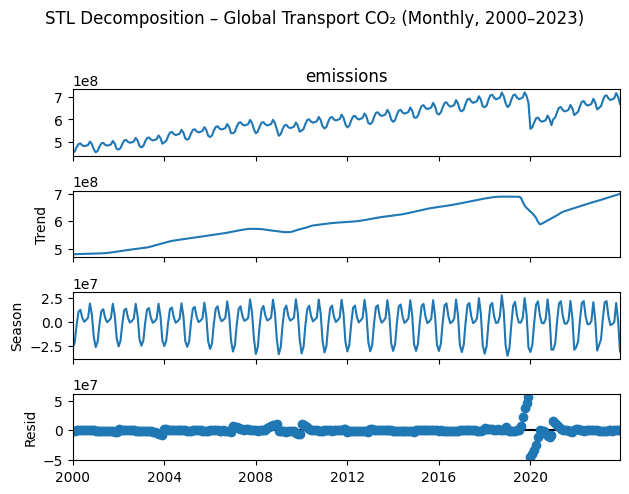

In [78]:
import xarray as xr, pandas as pd
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
from pathlib import Path

nc = Path("data/curated/edgar_transport_2000_2024_rawcombined_fixedtime.nc")
ds = xr.open_dataset(nc, engine="h5netcdf", decode_times=True)
v = "emissions" if "emissions" in ds.data_vars else list(ds.data_vars)[0]

y = ds[v].sum(dim=("lat","lon")).to_series()           # monthly global total
y.index = pd.to_datetime(y.index)                      # ensure DateTimeIndex (monthly)
stl = STL(y, period=12, robust=True).fit()

plt.figure(figsize=(12,6))
stl.plot()
plt.suptitle("STL Decomposition – Global Transport CO₂ (Monthly, 2000–2023)", y=1.02)
plt.tight_layout()
plt.show()

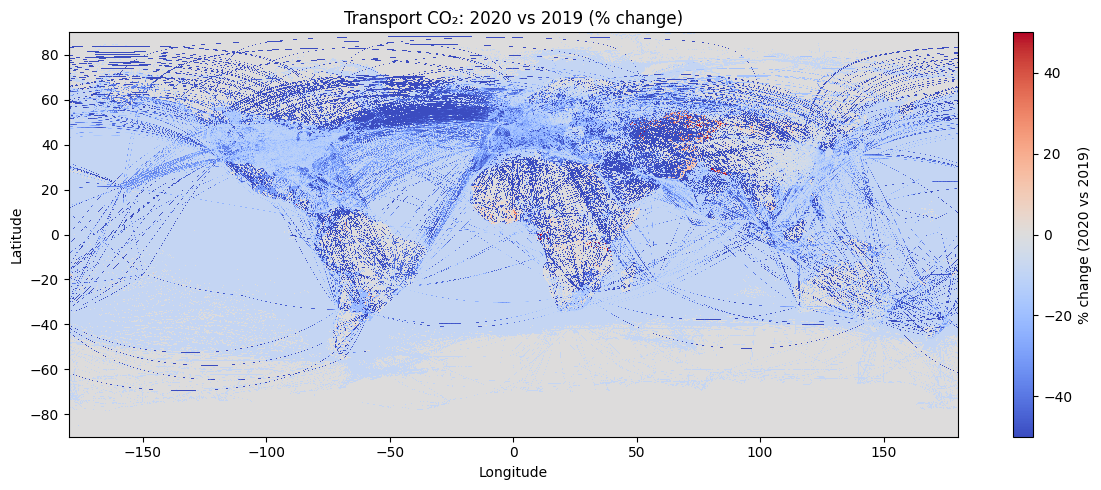

In [1]:
import xarray as xr, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

nc = Path("data/curated/edgar_transport_2000_2024_rawcombined_fixedtime.nc")
ds = xr.open_dataset(nc, engine="h5netcdf", decode_times=True)
v = "emissions" if "emissions" in ds.data_vars else list(ds.data_vars)[0]

# annual sums
ann = ds[v].groupby("time.year").sum(dim="time")
a2019 = ann.sel(year=2019)
a2020 = ann.sel(year=2020)

pct = (a2020 - a2019) / (a2019 + 1e-12) * 100.0        # % change, guard small denom

# wrap lon 0..360 → -180..180 for nicer plotting
lon = ds["lon"].values
lon_wrap = np.where(lon > 180, lon - 360, lon)

plt.figure(figsize=(12,5))
im = plt.pcolormesh(lon_wrap, ds["lat"].values, pct.values,
                    shading="auto", cmap="coolwarm", vmin=-50, vmax=50)
plt.colorbar(im, label="% change (2020 vs 2019)")
plt.title("Transport CO₂: 2020 vs 2019 (% change)")
plt.xlabel("Longitude"); plt.ylabel("Latitude"); plt.tight_layout(); plt.show()

In [2]:
# Export curated Parquet tables to CSV + build an all-in-one YEARLY CSV for MCP ingestion
from pathlib import Path
import pandas as pd

CUR = Path("data/curated")

paths = {
    "city-month": CUR / "city-month" / "transport_city_month.parquet",
    "city-year": CUR / "city-year" / "transport_city_year.parquet",
    "admin1-month": CUR / "admin1-month" / "transport_admin1_month.parquet",
    "admin1-year": CUR / "admin1-year" / "transport_admin1_year.parquet",
    "country-month": CUR / "country-month" / "transport_country_month.parquet",
    "country-year": CUR / "country-year" / "transport_country_year.parquet",
}


def _to_csv_if_exists(parq_path: Path, csv_path: Path):
    if not parq_path.exists():
        print(f"[csv] skip (missing): {parq_path}")
        return None
    df = pd.read_parquet(parq_path)
    df.to_csv(csv_path, index=False)
    print(f"[csv] wrote {csv_path}  rows={len(df):,}")
    return df


# 1) Write per-table CSVs
csv_written = {}
for key, pq in paths.items():
    csv = pq.with_suffix(".csv")
    df = _to_csv_if_exists(pq, csv)
    if df is not None:
        csv_written[key] = csv

# 2) Build ALL-IN-ONE (YEARLY) CSV: city + admin1 + country
year_parts = []

# City-year ➜ standardize columns
cy_pq = paths["city-year"]
if cy_pq.exists():
    cy = pd.read_parquet(cy_pq).copy()
    cy = cy.rename(columns={
        "city_id": "geo_id",
        "city_name": "geo_name"
    })
    cy["level"] = "city"
    cy = cy[["level", "geo_id", "geo_name", "admin1_name", "country_name", "iso3", "year", "emissions_tonnes", "MtCO2"]]
    year_parts.append(cy)

# Admin1-year
a1_pq = paths["admin1-year"]
if a1_pq.exists():
    a1 = pd.read_parquet(a1_pq).copy()
    a1 = a1.rename(columns={
        "admin1_geoid": "geo_id",
        "admin1_name": "geo_name"
    })
    # admin1-year already has country_name and iso3 in your pipeline
    # if not, you could map from admin0 here
    a1["level"] = "admin1"
    # ensure missing columns exist
    for col in ["country_name", "iso3"]:
        if col not in a1.columns:
            a1[col] = pd.NA
    a1 = a1[["level", "geo_id", "geo_name", "country_name", "iso3", "year", "emissions_tonnes", "MtCO2"]]
    # align schema with city (admin1 has no admin1_name separate; geo_name is the admin1 name)
    a1.insert(3, "admin1_name", a1["geo_name"])
    year_parts.append(a1)

# Country-year
c0_pq = paths["country-year"]
if c0_pq.exists():
    c0 = pd.read_parquet(c0_pq).copy()
    c0 = c0.rename(columns={"iso3": "geo_id", "country_name": "geo_name"})
    c0["level"] = "country"
    # countries naturally have no admin1_name
    c0["admin1_name"] = pd.NA
    # keep also country_name, iso3 for consistency (country_name=geo_name, iso3=geo_id)
    c0["country_name"] = c0["geo_name"]
    c0["iso3"] = c0["geo_id"]
    c0 = c0[["level", "geo_id", "geo_name", "admin1_name", "country_name", "iso3", "year", "emissions_tonnes", "MtCO2"]]
    year_parts.append(c0)

if year_parts:
    year_all = pd.concat(year_parts, ignore_index=True)
    out = CUR / "year_all_levels.csv"
    year_all.to_csv(out, index=False)
    print(f"[csv] wrote ALL-IN-ONE yearly → {out}  rows={len(year_all):,}")
else:
    print("[csv] no yearly parts found; skipped all-in-one.")

# 3) (Optional) Build ALL-IN-ONE (MONTHLY) CSV — large file, enable if needed
BUILD_MONTH_ALL = False
if BUILD_MONTH_ALL:
    month_parts = []
    # City-month
    cm_pq = paths["city-month"]
    if cm_pq.exists():
        cm = pd.read_parquet(cm_pq).copy()
        cm = cm.rename(columns={"city_id": "geo_id", "city_name": "geo_name"})
        cm["level"] = "city"
        # ensure admin1_name/country_name/iso3 exist
        for col in ["admin1_name", "country_name", "iso3"]:
            if col not in cm.columns: cm[col] = pd.NA
        cm = cm[
            ["level", "time", "geo_id", "geo_name", "admin1_name", "country_name", "iso3", "emissions_tonnes", "MtCO2"]]
        month_parts.append(cm)
    # Admin1-month
    a1m_pq = paths["admin1-month"]
    if a1m_pq.exists():
        a1m = pd.read_parquet(a1m_pq).copy()
        a1m = a1m.rename(columns={"admin1_geoid": "geo_id", "admin1_name": "geo_name"})
        a1m["level"] = "admin1"
        for col in ["country_name", "iso3"]:
            if col not in a1m.columns: a1m[col] = pd.NA
        a1m.insert(4, "admin1_name", a1m["geo_name"])
        a1m = a1m[
            ["level", "time", "geo_id", "geo_name", "admin1_name", "country_name", "iso3", "emissions_tonnes", "MtCO2"]]
        month_parts.append(a1m)
    # Country-month
    c0m_pq = paths["country-month"]
    if c0m_pq.exists():
        c0m = pd.read_parquet(c0m_pq).copy()
        c0m = c0m.rename(columns={"iso3": "geo_id", "country_name": "geo_name"})
        c0m["level"] = "country"
        c0m["admin1_name"] = pd.NA
        c0m["country_name"] = c0m["geo_name"]
        c0m["iso3"] = c0m["geo_id"]
        c0m = c0m[
            ["level", "time", "geo_id", "geo_name", "admin1_name", "country_name", "iso3", "emissions_tonnes", "MtCO2"]]
        month_parts.append(c0m)

    if month_parts:
        month_all = pd.concat(month_parts, ignore_index=True)
        outm = CUR / "month_all_levels.csv"
        month_all.to_csv(outm, index=False)
        print(f"[csv] wrote ALL-IN-ONE monthly → {outm}  rows={len(month_all):,}")
    else:
        print("[csv] no monthly parts found; skipped month all-in-one.")

[csv] wrote data/curated/city-month/transport_city_month.csv  rows=3,087,924
[csv] wrote data/curated/city-year/transport_city_year.csv  rows=257,327
[csv] wrote data/curated/admin1-month/transport_admin1_month.csv  rows=1,253,376
[csv] wrote data/curated/admin1-year/transport_admin1_year.csv  rows=104,448
[csv] wrote data/curated/country-month/transport_country_month.csv  rows=64,740
[csv] wrote data/curated/country-year/transport_country_year.csv  rows=5,395
[csv] wrote ALL-IN-ONE yearly → data/curated/year_all_levels.csv  rows=367,170


In [3]:

# Consolidate all CSVs (normal + expanded) into one folder for MCP ingestion
from pathlib import Path
import pandas as pd, hashlib

CUR = Path("data/curated")
CSV_DIR = Path("data/csv_datasets")
CSV_DIR.mkdir(parents=True, exist_ok=True)

# List of base parquet→csv mappings
targets = {
    "city-month": CUR / "city-month" / "transport_city_month.parquet",
    "city-year": CUR / "city-year" / "transport_city_year.parquet",
    "admin1-month": CUR / "admin1-month" / "transport_admin1_month.parquet",
    "admin1-year": CUR / "admin1-year" / "transport_admin1_year.parquet",
    "country-month": CUR / "country-month" / "transport_country_month.parquet",
    "country-year": CUR / "country-year" / "transport_country_year.parquet",
    "city-month-expanded": CUR / "city-month" / "transport_city_month_expanded.parquet",
    "city-year-expanded": CUR / "city-year" / "transport_city_year_expanded.parquet",
    "year-all": CUR / "year_all_levels.csv",  # already csv
}

csv_paths = {}


def write_csv_from_parquet(pq_path, out_csv):
    if not pq_path.exists():
        print(f"[skip] missing {pq_path}")
        return None
    df = pd.read_parquet(pq_path)
    df.to_csv(out_csv, index=False)
    print(f"[csv] wrote {out_csv} rows={len(df):,}")
    return out_csv


for key, path in targets.items():
    out_csv = CSV_DIR / f"{path.stem}.csv"
    if path.suffix == ".parquet":
        csv = write_csv_from_parquet(path, out_csv)
    else:
        # already csv, just copy into CSV_DIR
        import shutil

        shutil.copy(path, out_csv)
        print(f"[copy] {path} → {out_csv}")
        csv = out_csv
    if csv:
        csv_paths[key] = out_csv

# Optional: gzip all csvs
import gzip, shutil

for key, path in csv_paths.items():
    gz_path = path.with_suffix(".csv.gz")
    with open(path, "rb") as f_in, gzip.open(gz_path, "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)
    print(f"[gzip] {path.name} → {gz_path.name}")

# Checksums + row counts
with open(CSV_DIR / "checksums.txt", "w") as fout:
    for key, path in csv_paths.items():
        data = path.read_bytes()
        sha = hashlib.sha256(data).hexdigest()
        nrows = sum(1 for _ in open(path)) - 1  # minus header
        fout.write(f"{path.name}\trows={nrows}\tsha256={sha}\n")
print("[done] All CSVs consolidated in", CSV_DIR)

[csv] wrote data/csv_datasets/transport_city_month.csv rows=3,087,924
[csv] wrote data/csv_datasets/transport_city_year.csv rows=257,327
[csv] wrote data/csv_datasets/transport_admin1_month.csv rows=1,253,376
[csv] wrote data/csv_datasets/transport_admin1_year.csv rows=104,448
[csv] wrote data/csv_datasets/transport_country_month.csv rows=64,740
[csv] wrote data/csv_datasets/transport_country_year.csv rows=5,395
[csv] wrote data/csv_datasets/transport_city_month_expanded.csv rows=3,052,668
[csv] wrote data/csv_datasets/transport_city_year_expanded.csv rows=254,389
[copy] data/curated/year_all_levels.csv → data/csv_datasets/year_all_levels.csv
[gzip] transport_city_month.csv → transport_city_month.csv.gz
[gzip] transport_city_year.csv → transport_city_year.csv.gz
[gzip] transport_admin1_month.csv → transport_admin1_month.csv.gz
[gzip] transport_admin1_year.csv → transport_admin1_year.csv.gz
[gzip] transport_country_month.csv → transport_country_month.csv.gz
[gzip] transport_country_year

In [4]:
# Build a lightweight manifest JSON for MCP ingestion/routing
from pathlib import Path
import json
import pandas as pd

CUR = Path("data/curated")
MANIFEST = CUR / "manifest_mcp.json"

# declare the CSVs we expect (add/remove as needed)
tables = [
    # YEARLY (primary for LLM/RAG)
    ("city-year", CUR / "city-year" / "transport_city_year.csv", "city", "year"),
    ("admin1-year", CUR / "admin1-year" / "transport_admin1_year.csv", "admin1", "year"),
    ("country-year", CUR / "country-year" / "transport_country_year.csv", "country", "year"),
    ("year-all", CUR / "year_all_levels.csv", "mixed", "year"),  # denormalized stack

    # MONTHLY (optional drill-down)
    ("city-month", CUR / "city-month" / "transport_city_month.csv", "city", "month"),
    ("admin1-month", CUR / "admin1-month" / "transport_admin1_month.csv", "admin1", "month"),
    ("country-month", CUR / "country-month" / "transport_country_month.csv", "country", "month"),

    # City “expanded” variant (optional)
    ("city-year-expanded", CUR / "city-year" / "transport_city_year_expanded.csv", "city_expanded", "year"),
    ("city-month-expanded", CUR / "city-month" / "transport_city_month_expanded.csv", "city_expanded", "month"),
]


def sniff_schema(csv_path: Path) -> dict:
    if not csv_path.exists():
        return {"exists": False, "columns": [], "dtypes": {}}
    # read no rows → just header & dtypes guess (fast)
    try:
        df0 = pd.read_csv(csv_path, nrows=0)
    except Exception:
        # fallback: try pyarrow (optional) or return empty schema
        try:
            import pyarrow as pa, pyarrow.csv as pacsv
            tbl = pacsv.read_csv(csv_path, read_options=pacsv.ReadOptions(autogenerate_column_names=False))
            cols = [f.name for f in tbl.schema]
            return {"exists": True, "columns": cols, "dtypes": {c: "unknown" for c in cols}}
        except Exception:
            return {"exists": True, "columns": [], "dtypes": {}}
    cols = df0.columns.tolist()
    dtypes = {c: str(df0.dtypes.get(c, "object")) for c in cols}
    return {"exists": True, "columns": cols, "dtypes": dtypes}


def describe(level: str, period: str) -> str:
    base = {
        "city": "City totals from EDGAR 0.1° grid aggregated by GHSL Urban Centres (strict/standard).",
        "city_expanded": "City totals with wider polygon buffer + nearest/Voronoi fill (expanded coverage).",
        "admin1": "State/Province totals (Admin-1, Natural Earth).",
        "country": "Country totals (Admin-0, Natural Earth).",
        "mixed": "Stacked view of city/admin1/country yearly totals (uniform schema).",
    }.get(level, "Aggregated totals.")
    return f"{base} Period={period}."


manifest = {
    "dataset": "EDGAR transport (v2024) — curated for ClimateGPT",
    "units": "tonnes CO2",
    "spatial_res": "0.1°",
    "temporal_res": "monthly, annual",
    "files": []
}

for key, path, level, period in tables:
    info = sniff_schema(path)
    entry = {
        "id": key,
        "level": level,  # city | admin1 | country | mixed | city_expanded
        "period": period,  # year | month
        "path": str(path),
        "exists": info["exists"],
        "columns": info["columns"],
        "dtypes": info["dtypes"],
        "primary_keys": (
            ["year", "geo_id"] if key in ("year-all",) else
            (["year", "city_id"] if level.startswith("city") and period == "year" else
             (["time", "city_id"] if level.startswith("city") else
              (["year", "admin1_geoid"] if level == "admin1" and period == "year" else
               (["time", "admin1_geoid"] if level == "admin1" else
                (["year", "iso3"] if level == "country" and period == "year" else
                 (["time", "iso3"] if level == "country" else []))))))
        ),
        "description": describe(level, period),
        # hint for MCP retrieval to target small files first
        "priority": 1 if (period == "year" and level != "city_expanded") else 2
    }
    manifest["files"].append(entry)

with open(MANIFEST, "w", encoding="utf-8") as f:
    json.dump(manifest, f, ensure_ascii=False, indent=2)

print(f"[manifest] wrote {MANIFEST}  | tracked files: {len(manifest['files'])}")
for f in manifest["files"]:
    print(f" - {f['id']}: exists={f['exists']}  period={f['period']}  level={f['level']}")

[manifest] wrote data/curated/manifest_mcp.json  | tracked files: 9
 - city-year: exists=True  period=year  level=city
 - admin1-year: exists=True  period=year  level=admin1
 - country-year: exists=True  period=year  level=country
 - year-all: exists=True  period=year  level=mixed
 - city-month: exists=True  period=month  level=city
 - admin1-month: exists=True  period=month  level=admin1
 - country-month: exists=True  period=month  level=country
 - city-year-expanded: exists=False  period=year  level=city_expanded
 - city-month-expanded: exists=False  period=month  level=city_expanded


In [1]:
# build_admin1_expanded.py
from pathlib import Path
import time, numpy as np, pandas as pd, xarray as xr, geopandas as gpd

CUR = Path("data/curated")
GRID_NC = CUR / "edgar_transport_2000_2024_rawcombined_fixedtime.nc"
ADMIN1_PATH = Path("data/geo/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp")
ADMIN0_PATH = Path("data/geo/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp")

CRS_WGS84 = "EPSG:4326"
CRS_METRIC = "EPSG:6933"   # equal-area meters
EXP_MAX_NEAREST_M = 350_000 # expanded nearest cap (~350 km) vs standard 250 km
EXP_BUFFER_FIX = 0          # polygons already used as is for Admin-1 (not UCDB halos)

def ensure_wgs84(gdf, label):
    if gdf.crs is None: raise ValueError(f"{label} CRS None")
    return gdf if gdf.crs.to_epsg()==4326 else gdf.to_crs(4326)

def pick_col(gdf, cands, label, required=True):
    for c in cands:
        if c in gdf.columns: return c
    if required: raise ValueError(f"[{label}] none of {cands}")
    return None

def clean(s): return s.astype("string").str.replace("\ufeff","",regex=False).str.strip()

t0 = time.time()
print("[A1X] load grid")
ds = xr.open_dataset(GRID_NC, engine="h5netcdf", decode_times=True)
v = "emissions" if "emissions" in ds.data_vars else list(ds.data_vars)[0]
n_time, n_lat, n_lon = ds.sizes["time"], ds.sizes["lat"], ds.sizes["lon"]
lat_vals, lon_vals = ds["lat"].values, ds["lon"].values
lat_rep = np.repeat(lat_vals, n_lon)
lon_tile = np.tile(lon_vals, n_lat)
lon_wrap = np.where(lon_tile > 180, lon_tile - 360, lon_tile)
n_cells = n_lat*n_lon

print("[A1X] load admin layers")
adm1 = ensure_wgs84(gpd.read_file(ADMIN1_PATH), "admin1").copy()
adm0 = ensure_wgs84(gpd.read_file(ADMIN0_PATH), "admin0").copy()
adm0["geometry"] = adm0.geometry.buffer(0)

A1_NAME = pick_col(adm1, ["name_en","NAME_1","name","GN_NAME"], "admin1(name)")
A1_CODE = pick_col(adm1, ["adm1_code","code_hasc","postal","gns_code"], "admin1(code)", required=False)
A0_ISO3 = pick_col(adm0, ["iso_a3","ISO_A3","ISO_A3_EH"], "admin0(iso3)")
A0_NAME = pick_col(adm0, ["name_en","NAME_EN","name","NAME"], "admin0(name)")

# attach iso3 to admin1 if not present
if "iso3" not in adm1.columns:
    j = gpd.sjoin(adm1[[A1_NAME,"geometry"]], adm0[[A0_NAME,A0_ISO3,"geometry"]], how="left", predicate="within") \
        .drop(columns=["index_right"]).rename(columns={A0_ISO3:"iso3"})
    adm1 = adm1.join(j["iso3"])
adm1["iso3"] = clean(adm1["iso3"])
adm1["admin1_name"] = clean(adm1[A1_NAME])

if A1_CODE:
    adm1["admin1_geoid"] = clean(adm1[A1_CODE]) + "|" + adm1["iso3"].fillna("UNK")
else:
    adm1["admin1_geoid"] = adm1["admin1_name"] + "|" + adm1["iso3"].fillna("UNK")

# (optional) light buffer fix for slivers (kept 0 so shapes stay precise)
if EXP_BUFFER_FIX>0:
    a1b = adm1.to_crs(CRS_METRIC)
    a1b["geometry"] = a1b.geometry.buffer(EXP_BUFFER_FIX)
    adm1 = a1b.to_crs(CRS_WGS84)

print("[A1X] build points and intersects")
pts = gpd.GeoDataFrame({"cid": np.arange(n_cells,dtype=np.int64)},
                       geometry=gpd.points_from_xy(lon_wrap, lat_rep), crs=CRS_WGS84)
joined = gpd.sjoin(pts, adm1[["admin1_geoid","admin1_name","iso3","geometry"]],
                   how="left", predicate="intersects").drop(columns=["index_right"])
joined["join_type"] = "intersects"; joined["distance_m"] = np.nan

miss = joined["admin1_geoid"].isna()
if miss.any():
    print(f"[A1X] nearest fallback for {int(miss.sum()):,} cells (≤{EXP_MAX_NEAREST_M/1000:.0f} km)")
    miss_idx = joined.index[miss]
    pts_m = pts.loc[miss_idx].to_crs(CRS_METRIC)
    a1_m  = adm1[["admin1_geoid","admin1_name","iso3","geometry"]].to_crs(CRS_METRIC)
    jn = gpd.sjoin_nearest(pts_m, a1_m, how="left", max_distance=EXP_MAX_NEAREST_M,
                           distance_col="distance_m").drop(columns=["index_right"])
    if jn.index.has_duplicates: jn = jn[~jn.index.duplicated(keep="first")]
    jn = jn.reindex(miss_idx)
    for c in ["admin1_geoid","admin1_name","iso3","distance_m"]:
        joined.loc[miss_idx,c] = jn[c].to_numpy()
    filled = miss_idx[jn["admin1_geoid"].notna().to_numpy()]
    joined.loc[filled,"join_type"] = "nearest"

# compact index
a1_index = pd.Index(joined.loc[joined["admin1_geoid"].notna(),"admin1_geoid"].astype("string")).drop_duplicates().sort_values()
a1_to_idx = dict(zip(a1_index, np.arange(len(a1_index), dtype=np.int32)))
cell_to_a1 = np.full(n_cells, -1, dtype=np.int32)
idxs = joined["admin1_geoid"].astype("string").map(a1_to_idx).fillna(-1).astype(np.int32).to_numpy()
cell_to_a1[joined["cid"].to_numpy()] = idxs

# meta arrays
adm1_meta = (adm1[["admin1_geoid","admin1_name","iso3"]]
             .drop_duplicates("admin1_geoid").set_index("admin1_geoid")
             .astype({"admin1_name":"string","iso3":"string"}))
adm1_meta.index = adm1_meta.index.astype("string")
a1_name = adm1_meta["admin1_name"].reindex(a1_index).fillna("Unknown").to_numpy()
a1_iso3 = adm1_meta["iso3"].reindex(a1_index).fillna("").to_numpy()

print("[A1X] aggregate month/year")
times = pd.to_datetime(ds["time"].values)
parts=[]
sel = cell_to_a1>=0
for tpos in range(n_time):
    arr = ds[v].isel(time=tpos).values.astype("float64", copy=False).reshape(-1)
    sums = np.bincount(cell_to_a1[sel], weights=arr[sel], minlength=len(a1_index))
    nz = np.flatnonzero(sums)
    if nz.size:
        parts.append(pd.DataFrame({
            "time": np.repeat(times[tpos], nz.size),
            "admin1_geoid": a1_index[nz].to_numpy(),
            "admin1_name": a1_name[nz],
            "iso3": a1_iso3[nz],
            "emissions_tonnes": sums[nz],
        }))

a1m = (pd.concat(parts, ignore_index=True)
       if parts else pd.DataFrame(columns=["time","admin1_geoid","admin1_name","iso3","emissions_tonnes"]))
a1m["MtCO2"] = a1m["emissions_tonnes"]/1e6
a1y = (a1m.assign(year=lambda d: pd.to_datetime(d["time"]).dt.year.astype("Int16"))
       .groupby(["admin1_geoid","admin1_name","iso3","year"], dropna=False, as_index=False)["emissions_tonnes"].sum())
a1y["MtCO2"] = a1y["emissions_tonnes"]/1e6

out_m = CUR/"admin1-month"/"transport_admin1_month_expanded.parquet"
out_y = CUR/"admin1-year"/"transport_admin1_year_expanded.parquet"
out_m.parent.mkdir(parents=True, exist_ok=True); out_y.parent.mkdir(parents=True, exist_ok=True)
a1m.to_parquet(out_m, index=False); a1y.to_parquet(out_y, index=False)
print("[A1X] wrote:", out_m, "|", out_y, f"(in {time.time()-t0:.1f}s)")

[A1X] load grid
[A1X] load admin layers
[A1X] build points and intersects
[A1X] nearest fallback for 4,337,350 cells (≤350 km)
[A1X] aggregate month/year
[A1X] wrote: data/curated/admin1-month/transport_admin1_month_expanded.parquet | data/curated/admin1-year/transport_admin1_year_expanded.parquet (in 387.2s)


In [2]:
# build_country_expanded.py
from pathlib import Path
import time, numpy as np, pandas as pd, xarray as xr, geopandas as gpd

CUR = Path("data/curated")
GRID_NC = CUR / "edgar_transport_2000_2024_rawcombined_fixedtime.nc"
ADMIN0_PATH = Path("data/geo/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp")

CRS_WGS84="EPSG:4326"; CRS_METRIC="EPSG:6933"
EXP_MAX_NEAREST_M = 250_000  # 250 km to pull near-coast ocean cells to nearest mainland

def ensure_wgs84(g,l):
    if g.crs is None: raise ValueError(f"{l} CRS None")
    return g if g.crs.to_epsg()==4326 else g.to_crs(4326)
def pick_col(g,cands,l,required=True):
    for c in cands:
        if c in g.columns: return c
    if required: raise ValueError(f"[{l}] none of {cands}")
    return None
def clean(s): return s.astype("string").str.replace("\ufeff","",regex=False).str.strip()

t0 = time.time()
print("[C0X] load grid")
ds = xr.open_dataset(GRID_NC, engine="h5netcdf", decode_times=True)
v = "emissions" if "emissions" in ds.data_vars else list(ds.data_vars)[0]
n_time, n_lat, n_lon = ds.sizes["time"], ds.sizes["lat"], ds.sizes["lon"]
lat_vals, lon_vals = ds["lat"].values, ds["lon"].values
lat_rep = np.repeat(lat_vals, n_lon)
lon_tile = np.tile(lon_vals, n_lat)
lon_wrap = np.where(lon_tile > 180, lon_tile - 360, lon_tile)
n_cells = n_lat*n_lon

print("[C0X] load admin0")
adm0 = ensure_wgs84(gpd.read_file(ADMIN0_PATH), "admin0").copy()
A0_NAME = pick_col(adm0, ["name_en","NAME_EN","name","NAME"], "admin0(name)")
A0_ISO3 = pick_col(adm0, ["iso_a3","ISO_A3","ISO_A3_EH"], "admin0(iso3)")
adm0["country_name"] = clean(adm0[A0_NAME]); adm0["iso3"] = clean(adm0[A0_ISO3])
adm0["geometry"] = adm0.geometry.buffer(0)

print("[C0X] build points")
pts = gpd.GeoDataFrame({"cid": np.arange(n_cells,dtype=np.int64)},
                       geometry=gpd.points_from_xy(lon_wrap, lat_rep), crs=CRS_WGS84)

print("[C0X] intersects")
j = gpd.sjoin(pts, adm0[["country_name","iso3","geometry"]], how="left", predicate="intersects") \
    .drop(columns=["index_right"])
j["join_type"]="intersects"; j["distance_m"]=np.nan

miss = j["iso3"].isna()
if miss.any():
    print(f"[C0X] nearest fallback for {int(miss.sum()):,} cells (≤{EXP_MAX_NEAREST_M/1000:.0f} km)")
    miss_idx = j.index[miss]
    pts_m = pts.loc[miss_idx].to_crs(CRS_METRIC)
    a0_m  = adm0[["country_name","iso3","geometry"]].to_crs(CRS_METRIC)
    jn = gpd.sjoin_nearest(pts_m, a0_m, how="left", max_distance=EXP_MAX_NEAREST_M,
                           distance_col="distance_m").drop(columns=["index_right"])
    if jn.index.has_duplicates: jn = jn[~jn.index.duplicated(keep="first")]
    jn = jn.reindex(miss_idx)
    for c in ["country_name","iso3","distance_m"]:
        j.loc[miss_idx,c] = jn[c].to_numpy()
    filled = miss_idx[jn["iso3"].notna().to_numpy()]
    j.loc[filled,"join_type"] = "nearest"

# compact index
c0_index = pd.Index(j.loc[j["iso3"].notna(),"iso3"].astype("string")).drop_duplicates().sort_values()
c0_to_idx = dict(zip(c0_index, np.arange(len(c0_index), dtype=np.int32)))
cell_to_c0 = np.full(n_cells, -1, dtype=np.int32)
idxs = j["iso3"].astype("string").map(c0_to_idx).fillna(-1).astype(np.int32).to_numpy()
cell_to_c0[j["cid"].to_numpy()] = idxs
country_names = (adm0[["iso3","country_name"]]
                 .drop_duplicates("iso3").set_index("iso3")["country_name"]
                 .reindex(c0_index).fillna("Unknown").to_numpy())

print("[C0X] aggregate month/year")
times = pd.to_datetime(ds["time"].values)
parts=[]; sel = cell_to_c0>=0
for tpos in range(n_time):
    arr = ds[v].isel(time=tpos).values.astype("float64", copy=False).reshape(-1)
    sums = np.bincount(cell_to_c0[sel], weights=arr[sel], minlength=len(c0_index))
    nz = np.flatnonzero(sums)
    if nz.size:
        parts.append(pd.DataFrame({
            "time": np.repeat(times[tpos], nz.size),
            "iso3": c0_index[nz].to_numpy(),
            "country_name": country_names[nz],
            "emissions_tonnes": sums[nz],
        }))

c0m = (pd.concat(parts, ignore_index=True)
       if parts else pd.DataFrame(columns=["time","iso3","country_name","emissions_tonnes"]))
c0m["MtCO2"] = c0m["emissions_tonnes"]/1e6
c0y = (c0m.assign(year=lambda d: pd.to_datetime(d["time"]).dt.year.astype("Int16"))
       .groupby(["iso3","country_name","year"], dropna=False, as_index=False)["emissions_tonnes"].sum())
c0y["MtCO2"] = c0y["emissions_tonnes"]/1e6

out_m = CUR/"country-month"/"transport_country_month_expanded.parquet"
out_y = CUR/"country-year"/"transport_country_year_expanded.parquet"
out_m.parent.mkdir(parents=True, exist_ok=True); out_y.parent.mkdir(parents=True, exist_ok=True)
c0m.to_parquet(out_m, index=False); c0y.to_parquet(out_y, index=False)
print("[C0X] wrote:", out_m, "|", out_y, f"(in {time.time()-t0:.1f}s)")

[C0X] load grid
[C0X] load admin0
[C0X] build points
[C0X] intersects
[C0X] nearest fallback for 4,337,327 cells (≤250 km)
[C0X] aggregate month/year
[C0X] wrote: data/curated/country-month/transport_country_month_expanded.parquet | data/curated/country-year/transport_country_year_expanded.parquet (in 1322.9s)


In [3]:
import pandas as pd
from pathlib import Path

paths = [
    "data/curated/city-month/transport_city_month_expanded.parquet",
    "data/curated/city-year/transport_city_year_expanded.parquet",
    "data/curated/admin1-month/transport_admin1_month_expanded.parquet",
    "data/curated/admin1-year/transport_admin1_year_expanded.parquet",
    "data/curated/country-month/transport_country_month_expanded.parquet",
    "data/curated/country-year/transport_country_year_expanded.parquet",
]

for p in paths:
    path = Path(p)
    if path.exists():
        df = pd.read_parquet(path)
        print(f"{path.name}: rows={len(df):,}, cols={list(df.columns)}")
    else:
        print(f"❌ Missing: {path}")

transport_city_month_expanded.parquet: rows=3,052,668, cols=['time', 'city_id', 'city_name', 'admin1_name', 'country_name', 'iso3', 'emissions_tonnes', 'MtCO2']
transport_city_year_expanded.parquet: rows=254,389, cols=['city_id', 'city_name', 'admin1_name', 'country_name', 'iso3', 'year', 'emissions_tonnes', 'MtCO2']
transport_admin1_month_expanded.parquet: rows=1,253,664, cols=['time', 'admin1_geoid', 'admin1_name', 'iso3', 'emissions_tonnes', 'MtCO2']
transport_admin1_year_expanded.parquet: rows=104,472, cols=['admin1_geoid', 'admin1_name', 'iso3', 'year', 'emissions_tonnes', 'MtCO2']
transport_country_month_expanded.parquet: rows=67,968, cols=['time', 'iso3', 'country_name', 'emissions_tonnes', 'MtCO2']
transport_country_year_expanded.parquet: rows=5,664, cols=['iso3', 'country_name', 'year', 'emissions_tonnes', 'MtCO2']


In [4]:
df.head(5)

,iso3,country_name,year,emissions_tonnes,MtCO2
0,-99,Dhekelia Cantonment,2000,1.862050e+08,186.204970
1,-99,Dhekelia Cantonment,2001,1.872499e+08,187.249896
2,-99,Dhekelia Cantonment,2002,1.893812e+08,189.381152
3,-99,Dhekelia Cantonment,2003,1.889871e+08,188.987104
4,-99,Dhekelia Cantonment,2004,1.939889e+08,193.988867
